# 0. Installing geemap

For this work is necesary install geemap library. To do it, follow the next page:

* https://geemap.org/installation/

# 1. Filtring by target contries

In [1]:
# import libraries
import os
#import fiona
import ee
import geemap
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Trigger the authentication flow
ee.Authenticate()

# Initialize the library
ee.Initialize()

Opening in existing browser session.


MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0



Enter verification code:  4/1AWgavdcX-AiPxdd1WsLuHH4Xi7sNL4KuuvoqEPXSTBhmAjyYQczczx-rliU



Successfully saved authorization token.


In [3]:
# Target countries: Option 1
listCountries = ['Argentina', 'Bolivia', 'Brazil', 'Colombia', 'Ecuador',
                 'Guatemala', 'Honduras', 'Mexico', 'Peru', 'Venezuela']

# Load dataset
dataset = ee.FeatureCollection("FAO/GAUL/2015/level2")

# Function to filter by country
def filterCountry(country):
    countries = ee.FeatureCollection("FAO/GAUL/2015/level2")
    filter_ = countries.filter(ee.Filter.eq('ADM0_NAME', country))
    return filter_

# create a list using the previous function to filter the nine countries
list_filterCountries = [filterCountry(i) for i in listCountries]

# Join the nine countries
combinedCountries = list_filterCountries[0].merge(
    list_filterCountries[1]).merge(
    list_filterCountries[2]).merge(
    list_filterCountries[3]).merge(
    list_filterCountries[4]).merge(
    list_filterCountries[5]).merge(
    list_filterCountries[6]).merge(
    list_filterCountries[7]).merge(
    list_filterCountries[8]).merge(
    list_filterCountries[9])

# visualize the map
Map = geemap.Map()
tyleParams = {
    'fillColor': 'b5ffb4',
    'color': '00909F',
    'width': 1.0
}

Map.addLayer(combinedCountries, tyleParams, 'Countries', 1)

Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
# Filter target countries: Option 2
listCountries = ['Argentina', 'Bolivia', 'Brazil', 'Colombia', 'Ecuador',
                 'Guatemala', 'Honduras', 'Mexico', 'Peru', 'Venezuela']

# Load dataset
dataset = ee.FeatureCollection("FAO/GAUL/2015/level2")

targetCountries = dataset.filter(ee.Filter.inList(
  'ADM0_NAME', listCountries));

# Visualize map
Map = geemap.Map()
tyleParams = {
    'fillColor': 'b5ffb4',
    'color': '00909F',
    'width': 1.0
}

Map.addLayer(targetCountries, tyleParams, 'Countries', 1)

Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [5]:
# Calculate area in square kilometers
def areaCountries(feature):
    area = feature.geometry().area().divide(1e6)
    return feature.set('areaSqKm', area)

result2 = targetCountries.map(areaCountries);

Map.addLayer(result2, tyleParams, 'TargetCountries', 1)

#Map.addLayerControl()
Map

Map(bottom=556.0, center=[-88.34202013667787, 313.9453125], controls=(WidgetControl(options=['position', 'tran…

# 2. Global Forest Change

## 2.1 Quantifying Forest Change

### 2.1.1. Select bands

In [6]:
# Load Global Forest Change dataset
gfc2020 = ee.Image("UMD/hansen/global_forest_change_2020_v1_8")

# selecting bands
treecover = gfc2020.select(['treecover2000'])
lossImage = gfc2020.select(['loss'])
lossYearImage = gfc2020.select(['lossyear'])
gainImange = gfc2020.select(['gain'])

In [7]:
# Defining the pixel size
scale = lossImage.projection().nominalScale()
print('In square meters: ', scale.getInfo())

In square meters:  27.829872698318393


### 2.1.1.  Defining forest to thresholds of greater than 30, 50 and 70%

In [8]:
# treecover grater than 70%
treecover70 = treecover.gte(70).updateMask(treecover.gte(70))

#treecover grather than 50%
treecover50 = treecover.gte(50).updateMask(treecover.gte(50))

#treecover grather than 30%
treecover30 = treecover.gte(30).updateMask(treecover.gte(30))

# Add tree covers
Map.addLayer(treecover70, {
    'palette': ['00FF00'],
}, 'Forest_70')

Map.addLayer(treecover50, {
    'palette': ['00FF00']
}, 'Forest_50')

Map.addLayer(treecover30, {
    'palette': ['00FF00']
}, 'Forest_30')

Map

Map(bottom=1085.0, center=[-68.78414378041504, 286.34765625000006], controls=(WidgetControl(options=['position…

# 3. Zonal Statistics

In [9]:
# definiting temporal scale
consecutive_numbers = np.arange(1, 21)
years = np.arange(2001, 2021)

consecutive_numbers, years

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]))

In [10]:
list_lossyear = [lossYearImage.eq(i+1).mask(lossYearImage.eq(i+1)) for i in range(len(consecutive_numbers))]

In [11]:
# create a list with names to download the zonal statistic
lossyear70 = ['lossyear70_' + str(i) for i in years]

lossyear50 = ['lossyear50_' + str(i) for i in years]

lossyear30 = ['lossyear30_' + str(i) for i in years]

In [12]:
# Use And() method to create loss band by year according to the porcentage of treecover previously defined
deforestation50 = [i.And(treecover50) for i in list_lossyear]
deforestation70 = [i.And(treecover70) for i in list_lossyear]
deforestation30 = [i.And(treecover30) for i in list_lossyear]

In [13]:
# Add layers
Map = geemap.Map(center=(4, -75), zoom=8)

Map.addLayer(list_lossyear[9], {'palette': ['000000']}, 'lossYear')
Map.addLayer(deforestation50[9], {'palette': ['00FF00']}, 'deforestation_50')
Map.addLayer(deforestation70[9], {'palette': ['FF0000']}, 'deforestation_70')
Map.addLayer(deforestation30[0], {'palette': ['FF0000']}, 'deforestation_30')
Map

Map(center=[4, -75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

## 3.1. For each loss year

In [14]:
# This is to split the state of Brazil into parts to reduce computational process.
lista1 = [i for i in range(6333, 8171)]
lista2 = [i for i in range(8171, 10008)]
lista3 = [i for i in range(10008, 11843)]

print(lista1[-1], lista2[-1], lista3[-1])

8170 10007 11842


In [15]:
# filter by target countries
Brazil = result2.filter(ee.Filter.eq(
  'ADM0_NAME', 'Brazil'));

StatesB1 = Brazil.filter(ee.Filter.inList('ADM2_CODE', lista1))
StatesB2 = Brazil.filter(ee.Filter.inList('ADM2_CODE', lista2))
StatesB3 = Brazil.filter(ee.Filter.inList('ADM2_CODE', lista3))

In [ ]:
# This code piece generate one csv file by each loss year and country
country = StatesB1
for i in range(len(consecutive_numbers)):
    out_dir = os.path.join('outputs_zonalStatistic')
    out_countries_stats = os.path.join(
        out_dir, lossyear50[i] + 'StatesB1'+'.csv')
    
    geemap.zonal_statistics(
        deforestation50[i],
        country,
        out_countries_stats,
        statistics_type='SUM',
        scale=scale.getInfo()
    )
#-------------------------------------------------------------------
# Load csv layers generated in the previous step

filename = r'outputs_zonalStatistic/'
#nn = np.arange(2001,2019,1)
filenames = ['lossyear50_' + str(f) + 'StatesB1'+'.csv' for f in years]

df_DEF_StatesB150 = [pd.read_csv(filename + j) for j in filenames]

# Calculate area in ha from zonal statistic result
for i in range(len(df_DEF_StatesB150)):
    df_DEF_StatesB150[i]['loss50_ha_' + str(years[i])] = (
        (df_DEF_StatesB150[i]['sum']*900)/10000
    )
    
# download only once the FeatureCollection of the countries in shape format
# Uncomment the next lines to download it ONLY ONCE.
# This is to get a base in shp format to join csv's fiels.
out_dir = os.path.join('outputs_zonalStatistic/countriesSHP')
out_countries_stats = os.path.join(out_dir, 'StatesB1_50.shp')
    
geemap.zonal_statistics(
    deforestation50[0], 
    country, 
    out_countries_stats, 
    statistics_type='SUM', 
    scale=27.829872698318393)
    
# Drop unnecesary columns
df_DEF_StatesB150_drop = []
for i in df_DEF_StatesB150:
    df_DEF_StatesB150_drop.append(i.drop([
        'sum', 'system:index', 'ADM1_CODE', 'EXP2_YEAR', 'ADM2_NAME', 
        'ADM1_NAME', 'DISP_AREA', 'Shape_Leng', 'STATUS', 'STR2_YEAR',
        'ADM0_NAME', 'ADM0_CODE', 'Shape_Area', 'areaSqKm'
    ], axis=1))
    
    
gpd_StatesB1_50 = gpd.read_file(r'outputs_zonalStatistic/countriesSHP/StatesB1_50.shp')
gpd_StatesB1_50 = gpd_StatesB1_50.drop(['sum'], axis=1)

gpd_StatesB1_50 = gpd_StatesB1_50.set_index('ADM2_CODE')

for i in df_DEF_StatesB150_drop:
    gpd_StatesB1_50 = pd.concat([gpd_StatesB1_50, i.set_index('ADM2_CODE')], axis=1)
    
#---------------------------------------------------------------------    
out_dir = os.path.join('outputs_zonalStatistic')
out_countries_stats = os.path.join(out_dir,
                                   'treecover2000_50_StatesB2.csv')
    
geemap.zonal_statistics(
    treecover50, 
    StatesB2, 
    out_countries_stats, 
    statistics_type='SUM',
    scale=scale.getInfo())

#---------------------------------------------------------------------
# concat treecover 50%
df_treecover2000_StatesB250 = pd.read_csv(
    r'outputs_zonalStatistic/treecover2000_50_StatesB2.csv')

df_treecover2000_StatesB250['forest_50'] = (
    df_treecover2000_StatesB250['sum']*774.501814405)/10000

df_treecover2000_StatesB250 = df_treecover2000_StatesB250.drop([
    'sum', 'system:index', 'ADM1_CODE', 'ADM2_NAME', 'EXP2_YEAR',
    'ADM1_NAME', 'DISP_AREA', 'Shape_Leng', 'STATUS', 'STR2_YEAR',
    'ADM0_NAME', 'ADM0_CODE', 'Shape_Area'], axis=1)

gpd_StatesB2_50 = pd.concat([
    gpd_StatesB2_50, df_treecover2000_StatesB250.set_index('ADM2_CODE')], axis=1)

gpd_StatesB2_50 = gpd_StatesB2_50.drop([
    'loss50_ha_2001', 'loss50_ha_2002', 
    'loss50_ha_2003', 'loss50_ha_2004',
    'loss50_ha_2005', 'loss50_ha_2006',
    'loss50_ha_2007', 'loss50_ha_2008'
], axis=1)


gpd_StatesB2_50.to_file('gpkg/V1/thresholds.gpkg', layer='StatesB2_50',
                        driver="GPKG")

In [ ]:
# filter for target countries
#StatesB1 = result2.filter(ee.Filter.eq(
#  'ADM0_NAME', 'StatesB1'));

out_dir = os.path.join('outputs_zonalStatistic')
out_countries_stats = os.path.join(out_dir,
                                   'treecover2000_50_StatesB1.csv')
    
geemap.zonal_statistics(
    treecover50, 
    country, 
    out_countries_stats, 
    statistics_type='SUM',
    scale=scale.getInfo())

#---------------------------------------------------------------------
# concat treecover 50%
df_treecover2000_StatesB150 = pd.read_csv(r'outputs_zonalStatistic/treecover2000_50_StatesB1.csv')

df_treecover2000_StatesB150['forest_50'] = (
    (df_treecover2000_StatesB150['sum']*900)/10000)

df_treecover2000_StatesB150 = df_treecover2000_StatesB150.drop(
    ['sum', 'system:index', 'ADM1_CODE', 'ADM2_NAME', 'EXP2_YEAR',
     'ADM1_NAME', 'DISP_AREA', 'Shape_Leng', 'STATUS', 'STR2_YEAR',
     'ADM0_NAME', 'ADM0_CODE', 'Shape_Area','areaSqKm'], 
    axis=1)

gpd_StatesB1_50 = pd.concat([
    gpd_StatesB1_50, 
    df_treecover2000_StatesB150.set_index('ADM2_CODE')], axis=1)

gpd_StatesB1_50 = gpd_StatesB1_50.drop(
    ['loss50_ha_2001', 'loss50_ha_2002', 
    'loss50_ha_2003', 'loss50_ha_2004',
    'loss50_ha_2005', 'loss50_ha_2006',
    'loss50_ha_2007', 'loss50_ha_2008'], axis=1)


gpd_StatesB1_50.to_file('gpkg/V1/thresholds.gpkg', layer='StatesB1_50', driver="GPKG")

gpd_StatesB1_50[['areaSqKm','forest_50']]

In [16]:
Map.addLayer(StatesB2, tyleParams, 'TargetCountries', 1)

#Map.addLayerControl()
Map

Map(bottom=32339.0, center=[4, -75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HB…

listCountries = ['Argentina', 'Bolivia', 'Brazil', 'Colombia', 'Ecuador',
                 'Guatemala', 'Honduras', 'Mexico', 'Peru', 'Venezuela']

In [51]:
def TargetCountries(country):
        # filter for target countries
    countryTarget = result2.filter(ee.Filter.eq(
      'ADM0_NAME', country));

    for i in range(len(consecutive_numbers)):
        out_dir = os.path.join('outputs_zonalStatistic')
        out_countries_stats = os.path.join(out_dir, lossyear50[i] + country+'.csv')

        geemap.zonal_statistics(
            deforestation50[i],
            countryTarget,
            out_countries_stats,
            statistics_type='SUM',
            scale=scale.getInfo()
        )
    #-------------------------------------------------------------------
    # Load csv layers generated in the previous step

    filename = r'outputs_zonalStatistic/'
    #nn = np.arange(2001,2019,1)
    filenames = ['lossyear50_' + str(f) +country+'.csv' for f in years]

    df_DEF_country50 = [pd.read_csv(filename + j) for j in filenames]

    # Calculate area in ha from result of the zonal statistic
    for i in range(len(df_DEF_country50)):
        df_DEF_country50[i]['loss50_ha_'+str(years[i])] = (df_DEF_country50[i]['sum']*900)/10000

    # download for only one time the FeatureCollection of the countries in shape format
    # Uncomment the next lines to download for the only one time
    # This is to get a base in shp format to join csv's fiels.
    out_dir = os.path.join('outputs_zonalStatistic/countriesSHP')
    out_countries_stats = os.path.join(out_dir, country+'.shp')

    geemap.zonal_statistics(
        deforestation50[0], 
        countryTarget, 
        out_countries_stats, 
        statistics_type='SUM', 
        scale=scale.getInfo())

    # Drop unnecesary columns
    df_DEF_country50_drop = []
    for i in df_DEF_country50:
        df_DEF_country50_drop.append(i.drop([
            'sum', 'system:index', 'ADM1_CODE', 'EXP2_YEAR', 'ADM2_NAME', 
            'ADM1_NAME', 'DISP_AREA', 'Shape_Leng', 'STATUS', 'STR2_YEAR',
            'ADM0_NAME', 'ADM0_CODE', 'Shape_Area', 'areaSqKm'
        ], axis=1))


    gpd_country_50 = gpd.read_file(r'outputs_zonalStatistic/countriesSHP/'+country+'.shp')
    gpd_country_50 = gpd_country_50.drop(['sum'], axis=1)

    gpd_country_50 = gpd_country_50.set_index('ADM2_CODE')

    for i in df_DEF_country50_drop:
        gpd_country_50 = pd.concat([gpd_country_50, i.set_index('ADM2_CODE')], axis=1)
        
        
    out_dir = os.path.join('outputs_zonalStatistic')
    out_countries_stats = os.path.join(out_dir,
                                       'treecover2000_50_'+country+'.csv')

    geemap.zonal_statistics(
        treecover50, 
        countryTarget, 
        out_countries_stats, 
        statistics_type='SUM',
        scale=scale.getInfo())

    #---------------------------------------------------------------------
    # concat treecover 50%
    df_treecover2000_country50 = pd.read_csv(r'outputs_zonalStatistic/treecover2000_50_'+country+'.csv')

    df_treecover2000_country50['forest_50'] = (df_treecover2000_country50['sum']*900)/10000

    df_treecover2000_country50 = df_treecover2000_country50.drop(['sum', 'system:index', 
                                                                  'ADM1_CODE', 'ADM2_NAME',
                                                                  'EXP2_YEAR', 'ADM1_NAME', 
                                                                  'DISP_AREA', 'Shape_Leng', 
                                                                  'STATUS', 'STR2_YEAR', 
                                                                  'ADM0_NAME', 'ADM0_CODE', 
                                                                  'Shape_Area'], axis=1)

    gpd_country_50 = pd.concat([
        gpd_country_50, df_treecover2000_country50.set_index('ADM2_CODE')], axis=1)

    gpd_country_50 = gpd_country_50.drop([
        'loss50_ha_2001', 'loss50_ha_2002', 
        'loss50_ha_2003', 'loss50_ha_2004',
        'loss50_ha_2005', 'loss50_ha_2006',
        'loss50_ha_2007', 'loss50_ha_2008'
    ], axis=1)


    gpd_country_50.to_file('gpkg/V1/thresholds.gpkg', layer=country, driver="GPKG")
    
    return gpd_country_50

In [61]:
TargetCountries('StatesB1')

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear50_2001Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear50_2002Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear50_2003Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear50_2004Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear50_2005Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Produ

,ADM1_CODE,ADM2_NAME,EXP2_YEAR,DISP_AREA,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,STR2_YEAR,ADM0_CODE,...,loss50_ha_2013,loss50_ha_2014,loss50_ha_2015,loss50_ha_2016,loss50_ha_2017,loss50_ha_2018,loss50_ha_2019,loss50_ha_2020,areaSqKm,forest_50
ADM2_CODE,,,,,,,,,,,,,,,,,,,,,
82755,432,12 de Octubre,3000,NO,Chaco,2.658120,Member State,Argentina,1992,12,...,839.302941,791.322000,759.268941,436.732941,1000.635882,1595.610000,293.998235,602.190706,2755.888846,68486.023059
82756,432,2 de Abril,3000,NO,Chaco,1.730701,Member State,Argentina,1992,12,...,282.600000,323.088706,18.090000,28.555059,51.660000,68.850000,159.750000,24.570000,1605.522768,15422.203765
82757,432,Fray Justo Santa Maria de Oro,3000,NO,Chaco,2.487062,Member State,Argentina,1992,12,...,68.940000,25.740000,17.550000,40.140000,44.370000,65.688000,78.107647,56.880000,2199.511417,13777.192235
82728,429,Florencio Varela,3000,NO,Buenos Aires,0.771865,Member State,Argentina,1993,12,...,1.530000,2.880000,0.900000,1.080000,1.710000,1.980000,0.090000,4.050000,190.427930,568.167176
82736,429,Presidente Peron,3000,NO,Buenos Aires,0.643710,Member State,Argentina,1993,12,...,0.810000,1.530000,0.090000,0.360000,0.180000,0.000000,0.000000,0.000000,120.688061,354.302118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4886,452,Simoca,3000,NO,Tucuman,2.123540,Member State,Argentina,1000,12,...,1255.475647,216.813882,79.687059,140.677412,138.563294,135.900000,40.770000,218.438824,1321.819427,35520.122824
4887,452,Tafi del Valle,3000,NO,Tucuman,2.851055,Member State,Argentina,1000,12,...,1.440000,0.360000,0.090000,0.540000,2.520000,0.000000,1.080000,0.090000,2790.123261,8451.907059
4888,452,Tafi Viejo,3000,NO,Tucuman,2.466420,Member State,Argentina,1000,12,...,264.089647,185.166000,99.397412,89.703176,133.380000,46.800000,86.310000,193.680000,1141.123607,66298.670824


In [30]:
listC = ['Bolivia', 'Colombia', 'Ecuador',
         'Guatemala', 'Honduras', 'Peru', 'Venezuela']

Computing statistics ...
Generating URL ...
Please wait ...
An error occurred while downloading. 
 Retrying ...
Generating URL ...
Please wait ...
An error occurred while downloading.


Exception: [Errno 22] Invalid argument: 'D:\\01_UdeR\\06_gee_UR\\Producida\\jupyter_notebook\\outputs_zonalStatistic\\lossyear50_2001ee.FeatureCollection({\n  "functionInvocationValue": {\n    "functionName": "Collection.filter",\n    "arguments": {\n      "collection": {\n        "functionInvocationValue": {\n          "functionName": "Collection.map",\n          "arguments": {\n            "baseAlgorithm": {\n              "functionDefinitionValue": {\n                "argumentNames": [\n                  "_MAPPING_VAR_0_0"\n                ],\n                "body": {\n                  "functionInvocationValue": {\n                    "functionName": "Element.set",\n                    "arguments": {\n                      "key": {\n                        "constantValue": "areaSqKm"\n                      },\n                      "object": {\n                        "argumentReference": "_MAPPING_VAR_0_0"\n                      },\n                      "value": {\n                        "functionInvocationValue": {\n                          "functionName": "Number.divide",\n                          "arguments": {\n                            "left": {\n                              "functionInvocationValue": {\n                                "functionName": "Geometry.area",\n                                "arguments": {\n                                  "geometry": {\n                                    "functionInvocationValue": {\n                                      "functionName": "Feature.geometry",\n                                      "arguments": {\n                                        "feature": {\n                                          "argumentReference": "_MAPPING_VAR_0_0"\n                                        }\n                                      }\n                                    }\n                                  }\n                                }\n                              }\n                            },\n                            "right": {\n                              "constantValue": 1000000.0\n                            }\n                          }\n                        }\n                      }\n                    }\n                  }\n                }\n              }\n            },\n            "collection": {\n              "functionInvocationValue": {\n                "functionName": "Collection.filter",\n                "arguments": {\n                  "collection": {\n                    "functionInvocationValue": {\n                      "functionName": "Collection.loadTable",\n                      "arguments": {\n                        "tableId": {\n                          "constantValue": "FAO\\GAUL\\2015\\level2"\n                        }\n                      }\n                    }\n                  },\n                  "filter": {\n                    "functionInvocationValue": {\n                      "functionName": "Filter.listContains",\n                      "arguments": {\n                        "leftValue": {\n                          "constantValue": [\n                            "Argentina",\n                            "Bolivia",\n                            "Brazil",\n                            "Colombia",\n                            "Ecuador",\n                            "Guatemala",\n                            "Honduras",\n                            "Mexico",\n                            "Peru",\n                            "Venezuela"\n                          ]\n                        },\n                        "rightField": {\n                          "constantValue": "ADM0_NAME"\n                        }\n                      }\n                    }\n                  }\n                }\n              }\n            }\n          }\n        }\n      },\n      "filter": {\n        "functionInvocationValue": {\n          "functionName": "Filter.equals",\n          "arguments": {\n            "leftField": {\n              "constantValue": "ADM0_NAME"\n            },\n            "rightValue": {\n              "constantValue": "Bolivia"\n            }\n          }\n        }\n      }\n    }\n  }\n})_.csv'

In [59]:
def TargetCountries30(country):
        # filter for target countries
    countryTarget = result2.filter(ee.Filter.eq(
      'ADM0_NAME', country));

    for i in range(len(consecutive_numbers)):
        out_dir = os.path.join('outputs_zonalStatistic')
        out_countries_stats = os.path.join(out_dir, lossyear30[i] + country+'.csv')

        geemap.zonal_statistics(
            deforestation30[i],
            countryTarget,
            out_countries_stats,
            statistics_type='SUM',
            scale=30
        )
    #-------------------------------------------------------------------
    # Load csv layers generated in the previous step

    filename = r'outputs_zonalStatistic/'
    #nn = np.arange(2001,2019,1)
    filenames = ['lossyear30_' + str(f) +country+'.csv' for f in years]

    df_DEF_country30 = [pd.read_csv(filename + j) for j in filenames]

    # Calculate area in ha from result of the zonal statistic
    for i in range(len(df_DEF_country30)):
        df_DEF_country30[i]['loss30_ha_'+str(years[i])] = (df_DEF_country30[i]['sum']*900)/10000

    # download for only one time the FeatureCollection of the countries in shape format
    # Uncomment the next lines to download for the only one time
    # This is to get a base in shp format to join csv's fiels.
    out_dir = os.path.join('outputs_zonalStatistic/countriesSHP')
    out_countries_stats = os.path.join(out_dir, country+'30.shp')

    geemap.zonal_statistics(
        deforestation30[0], 
        countryTarget, 
        out_countries_stats, 
        statistics_type='SUM', 
        scale=30)

    # Drop unnecesary columns
    df_DEF_country30_drop = []
    for i in df_DEF_country30:
        df_DEF_country30_drop.append(i.drop([
            'sum', 'system:index', 'ADM1_CODE', 'EXP2_YEAR', 'ADM2_NAME', 
            'ADM1_NAME', 'DISP_AREA', 'Shape_Leng', 'STATUS', 'STR2_YEAR',
            'ADM0_NAME', 'ADM0_CODE', 'Shape_Area', 'areaSqKm'
        ], axis=1))


    gpd_country_30 = gpd.read_file(r'outputs_zonalStatistic/countriesSHP/'+country+'30.shp')
    gpd_country_30 = gpd_country_30.drop(['sum'], axis=1)

    gpd_country_30 = gpd_country_30.set_index('ADM2_CODE')

    for i in df_DEF_country30_drop:
        gpd_country_30 = pd.concat([gpd_country_30, i.set_index('ADM2_CODE')], axis=1)
        
        
    out_dir = os.path.join('outputs_zonalStatistic')
    out_countries_stats = os.path.join(out_dir,
                                       'treecover2000_30_'+country+'.csv')

    geemap.zonal_statistics(
        treecover30, 
        countryTarget, 
        out_countries_stats, 
        statistics_type='SUM',
        scale=30)

    #---------------------------------------------------------------------
    # concat treecover 30%
    df_treecover2000_country30 = pd.read_csv(r'outputs_zonalStatistic/treecover2000_30_'+country+'.csv')

    df_treecover2000_country30['forest_30'] = (df_treecover2000_country30['sum']*900)/10000

    df_treecover2000_country30 = df_treecover2000_country30.drop(['sum', 'system:index', 'ADM1_CODE', 'ADM2_NAME', 'EXP2_YEAR',
           'ADM1_NAME', 'DISP_AREA', 'Shape_Leng', 'STATUS', 'STR2_YEAR',
           'ADM0_NAME', 'ADM0_CODE', 'Shape_Area'], axis=1)

    gpd_country_30 = pd.concat([
        gpd_country_30, df_treecover2000_country30.set_index('ADM2_CODE')], axis=1)

    gpd_country_30 = gpd_country_30.drop([
        'loss30_ha_2001', 'loss30_ha_2002', 
        'loss30_ha_2003', 'loss30_ha_2004',
        'loss30_ha_2005', 'loss30_ha_2006',
        'loss30_ha_2007', 'loss30_ha_2008'
    ], axis=1)


    gpd_country_30.to_file('gpkg/V1/thresholds.gpkg', layer=country+str(30), driver="GPKG")
    
    #return gpd_country_30

In [60]:
listC = ['Argentina', 'Bolivia', 'Colombia', 'Ecuador',
         'Guatemala', 'Honduras', 'Mexico', 'Peru', 'Venezuela']

for i in listC:
    TargetCountries30(i)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear30_2001Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear30_2002Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear30_2003Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear30_2004Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Producida\jupyter_notebook\outputs_zonalStatistic\lossyear30_2005Argentina.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\01_UdeR\06_gee_UR\Produ

In [ ]:
# filter for target countries
Brazil = result2.filter(ee.Filter.eq(
  'ADM0_NAME', 'Brazil'));

StatesB1 = Brazil.filter(ee.Filter.inList('ADM2_CODE', lista1))
StatesB2 = Brazil.filter(ee.Filter.inList('ADM2_CODE', lista2))
StatesB3 = Brazil.filter(ee.Filter.inList('ADM2_CODE', lista3))

In [17]:
geemap.show_youtube('ou-Xm3CLitM')

Output(layout=Layout(width='815px'))

# 4. Geopandas

In [51]:
listCountries = ['Argentina_30', 'Bolivia_30', 'StatesB1_30', 'StatesB2_30', 
                 'StatesB3_30', 'Colombia_30', 'Ecuador_30', 'Guatemala_30',
                 'Honduras_30', 'Mexico_30', 'Peru_30', 'Venezuela_30']
countiresH = [gpd.read_file("gpkg/V1/thresholds.gpkg", layer=i) for i in listCountries]
treshold_30 = pd.concat(countiresH)

treshold_30 = treshold_30.rename(columns={'loss30_ha_2009':'DEF30_2009', 'loss30_ha_2010':'DEF30_2010',
                            'loss30_ha_2011':'DEF30_2011', 'loss30_ha_2012':'DEF30_2012',
                            'loss30_ha_2013':'DEF30_2013', 'loss30_ha_2014':'DEF30_2014',
                            'loss30_ha_2015':'DEF30_2015', 'loss30_ha_2016':'DEF30_2016',
                            'loss30_ha_2017':'DEF30_2017', 'loss30_ha_2018':'DEF30_2018',
                            'loss30_ha_2019':'DEF30_2019', 'loss30_ha_2020':'DEF30_2020',
                            'forest_30':'FOREST30'})
treshold_30.to_file('gpkg/V1/thresholds.gpkg', layer='DATASET30', driver="GPKG")

/home/andresg/miniconda3/envs/gee2/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [67]:
listCountries = ['Argentina_50', 'Bolivia_50', 'StatesB1_50', 'StatesB2_50', 
                 'StatesB3_50', 'Colombia_50', 'Ecuador_50', 'Guatemala_50',
                 'Honduras_50', 'Mexico_50', 'Peru_50', 'Venezuela_50']
countiresH50 = [gpd.read_file("gpkg/V1/thresholds.gpkg", layer=i) for i in listCountries]
treshold_50 = pd.concat(countiresH50)

treshold_50 = treshold_50.rename(columns={'loss50_ha_2009':'DEF50_2009', 'loss50_ha_2010':'DEF50_2010',
                            'loss50_ha_2011':'DEF50_2011', 'loss50_ha_2012':'DEF50_2012',
                            'loss50_ha_2013':'DEF50_2013', 'loss50_ha_2014':'DEF50_2014',
                            'loss50_ha_2015':'DEF50_2015', 'loss50_ha_2016':'DEF50_2016',
                            'loss50_ha_2017':'DEF50_2017', 'loss50_ha_2018':'DEF50_2018',
                            'loss50_ha_2019':'DEF50_2019', 'loss50_ha_2020':'DEF50_2020',
                            'forest_50':'FOREST50'})
treshold_50.to_file('gpkg/V1/thresholds.gpkg', layer='DATASET50', driver="GPKG")

/home/andresg/miniconda3/envs/gee2/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [62]:
dataset_30 = gpd.read_file('SHP/V3/DATASET_30_V2.shp')
dataset_30 = dataset_30.drop(['DEF30_2009', 'DEF30_2010',
                  'DEF30_2011', 'DEF30_2012', 'DEF30_2013', 'DEF30_2014', 'DEF30_2015',
                  'DEF30_2016', 'DEF30_2017', 'DEF30_2018', 'DEF30_2019'], axis=1)
dataset_30.columns

Index(['fid', 'ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'STATUS',
       'ADM0_NAME', 'forest30ha', 'Area_ha', 'Area_sqKm',
       ...
       'events2011', 'events2012', 'events2013', 'events2014', 'events2015',
       'events2016', 'events2017', 'events2018', 'events2019', 'geometry'],
      dtype='object', length=452)

In [63]:
defList = ['DEF30_2009', 'DEF30_2010', 'DEF30_2011', 'DEF30_2012', 'DEF30_2013', 'DEF30_2014', 'DEF30_2015',
           'DEF30_2016', 'DEF30_2017', 'DEF30_2018', 'DEF30_2019']
#for i in defList:
dataset_30['DEF30_2009'] = treshold_30['DEF30_2009']

/home/andresg/miniconda3/envs/gee2/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  super().__setitem__(key, value)


ValueError: cannot reindex on an axis with duplicate labels

In [58]:
treshold_30.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'EXP2_YEAR', 'DISP_AREA',
       'ADM1_NAME', 'Shape_Leng', 'STATUS', 'ADM0_NAME', 'STR2_YEAR',
       'ADM0_CODE', 'Shape_Area', 'areaSqKm', 'DEF30_2009', 'DEF30_2010',
       'DEF30_2011', 'DEF30_2012', 'DEF30_2013', 'DEF30_2014', 'DEF30_2015',
       'DEF30_2016', 'DEF30_2017', 'DEF30_2018', 'DEF30_2019', 'DEF30_2020',
       'FOREST30', 'geometry'],
      dtype='object')

In [49]:
dataset_50_old = gpd.read_file('SHP/Dataset.shp')
dataset_50_old.drop(columns=['B', 'C'])

In [50]:
for i in dataset_50_old.columns:
    print(i)

ADM2_CODE
ADM1_CODE
ADM2_NAME
ADM1_NAME
Shape_Leng
STATUS
ADM0_NAME
Shape_Area
DEF30_2009
DEF30_2010
DEF30_2011
DEF30_2012
DEF30_2013
DEF30_2014
DEF30_2015
DEF30_2016
DEF30_2017
DEF30_2018
DEF30_2019
forest30ha
Area_ha
P_2009
P_2010
P_2011
P_2012
P_2013
P_2014
P_2015
P_2016
P_2017
P_2018
P_2019
GPD2009
GPD2010
GPD2011
GPD2012
GPD2013
GPD2014
GPD2015
GPD2016
GPD2017
GPD2018
GPD2019
%Forest30
geometry


## 4.1. Concat deforestation 30%

In [298]:
import fiona 
print(fiona.supported_drivers)

{'AeronavFAA': 'r', 'ARCGEN': 'r', 'BNA': 'raw', 'DXF': 'raw', 'CSV': 'raw', 'OpenFileGDB': 'r', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'GeoJSON': 'rw', 'GeoJSONSeq': 'rw', 'GPKG': 'rw', 'GML': 'raw', 'GPX': 'raw', 'GPSTrackMaker': 'raw', 'Idrisi': 'r', 'MapInfo File': 'raw', 'DGN': 'raw', 'PCIDSK': 'r', 'S57': 'r', 'SEGY': 'r', 'SUA': 'r', 'TopoJSON': 'r'}


# 7. Population density

In [230]:
gpd_countries_30_C.groupby(['ADM2_NAME']).count()

NameError: name 'gpd_countries_30_C' is not defined

In [64]:
Bolivia2009 = gpd.read_file("gpkg/Bolivia/Bolivia.gpkg", layer='Bolivia_2009')
Bolivia2010 = gpd.read_file("gpkg/Bolivia/Bolivia.gpkg", layer='Bolivia_2010')

In [68]:
Bolivia2009

,ADM2_CODE,ADM1_CODE,ADM2_NAME,EXP2_YEAR,DISP_AREA,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,STR2_YEAR,...,loss30_ha_2014,loss30_ha_2015,loss30_ha_2016,loss30_ha_2017,loss30_ha_2018,loss30_ha_2019,forest_30,Area_ha,2009_sum,geometry
0,6141,40443,Cercado,3000,NO,Beni,5.100036,Member State,Bolivia,1000,...,193.142118,49.698353,172.329529,301.811647,75.873176,147.427412,7500.248824,1.071420e+06,107049.900845,"POLYGON ((-65.11862 -13.97650, -65.06134 -13.9..."
1,6142,40443,General Jose Ballivi,3000,NO,Beni,15.941263,Member State,Bolivia,1000,...,1311.087882,300.705882,411.255529,488.081647,358.738588,763.707529,31941.860118,4.062328e+06,81567.392939,"POLYGON ((-67.56518 -14.04564, -67.56469 -14.0..."
2,6143,40443,Itenez,3000,NO,Beni,9.339853,Member State,Bolivia,1000,...,160.690941,55.807059,193.698353,667.550471,87.217059,144.594706,28219.785529,3.539026e+06,21195.638810,"POLYGON ((-64.31856 -13.26675, -64.31841 -13.2..."
3,6144,40443,Mamore,3000,NO,Beni,8.693663,Member State,Bolivia,1000,...,326.038941,50.061176,182.075294,202.874118,38.861294,94.803529,9123.931059,2.093389e+06,13149.495971,"POLYGON ((-65.34040 -13.59980, -65.33921 -13.5..."
4,40451,40443,Marban,3000,NO,Beni,7.106975,Member State,Bolivia,1000,...,293.936118,133.398706,368.732824,349.158000,172.495059,258.377294,12174.761294,1.472454e+06,16416.874579,"POLYGON ((-65.36799 -15.58893, -65.36782 -15.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,40537,40450,Avilez,3000,NO,Tarija,3.847494,Member State,Bolivia,1000,...,0.000000,0.000000,0.090000,0.000000,0.236118,0.000000,42.674118,2.643839e+05,20247.286552,"POLYGON ((-65.41817 -21.89328, -65.41816 -21.8..."
109,40541,40450,Burnet O'Connor,3000,NO,Tarija,4.455969,Member State,Bolivia,1000,...,56.445176,13.010118,49.094824,100.488000,25.700118,65.411294,5455.208118,5.035020e+05,22080.488984,"POLYGON ((-64.43968 -21.28080, -64.43936 -21.2..."
110,40538,40450,Cercado,3000,NO,Tarija,3.292585,Member State,Bolivia,1000,...,0.540000,0.360000,0.990000,0.630000,0.213529,3.148588,542.866235,2.132418e+05,197246.813152,"POLYGON ((-65.01058 -21.77264, -65.00834 -21.7..."
111,40539,40450,Gran Chaco,3000,NO,Tarija,8.383600,Member State,Bolivia,1000,...,178.601647,56.482588,153.556588,200.130000,148.869882,218.164941,19943.971412,1.852377e+06,139930.695681,"POLYGON ((-64.31810 -22.11851, -64.31737 -22.1..."


In [66]:
Bolivia_09_10 = Bolivia2009.merge(Bolivia2010)

In [67]:
Bolivia_09_10 

,ADM2_CODE,ADM1_CODE,ADM2_NAME,EXP2_YEAR,DISP_AREA,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,STR2_YEAR,...,loss30_ha_2015,loss30_ha_2016,loss30_ha_2017,loss30_ha_2018,loss30_ha_2019,forest_30,Area_ha,2009_sum,geometry,2010_sum
0,6141,40443,Cercado,3000,NO,Beni,5.100036,Member State,Bolivia,1000,...,49.698353,172.329529,301.811647,75.873176,147.427412,7500.248824,1.071420e+06,107049.900845,"POLYGON ((-65.11862 -13.97650, -65.06134 -13.9...",109815.775619
1,6142,40443,General Jose Ballivi,3000,NO,Beni,15.941263,Member State,Bolivia,1000,...,300.705882,411.255529,488.081647,358.738588,763.707529,31941.860118,4.062328e+06,81567.392939,"POLYGON ((-67.56518 -14.04564, -67.56469 -14.0...",82852.265495
2,6143,40443,Itenez,3000,NO,Beni,9.339853,Member State,Bolivia,1000,...,55.807059,193.698353,667.550471,87.217059,144.594706,28219.785529,3.539026e+06,21195.638810,"POLYGON ((-64.31856 -13.26675, -64.31841 -13.2...",21268.763817
3,6144,40443,Mamore,3000,NO,Beni,8.693663,Member State,Bolivia,1000,...,50.061176,182.075294,202.874118,38.861294,94.803529,9123.931059,2.093389e+06,13149.495971,"POLYGON ((-65.34040 -13.59980, -65.33921 -13.5...",13174.940578
4,40451,40443,Marban,3000,NO,Beni,7.106975,Member State,Bolivia,1000,...,133.398706,368.732824,349.158000,172.495059,258.377294,12174.761294,1.472454e+06,16416.874579,"POLYGON ((-65.36799 -15.58893, -65.36782 -15.5...",16566.624166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,40537,40450,Avilez,3000,NO,Tarija,3.847494,Member State,Bolivia,1000,...,0.000000,0.090000,0.000000,0.236118,0.000000,42.674118,2.643839e+05,20247.286552,"POLYGON ((-65.41817 -21.89328, -65.41816 -21.8...",20476.805751
109,40541,40450,Burnet O'Connor,3000,NO,Tarija,4.455969,Member State,Bolivia,1000,...,13.010118,49.094824,100.488000,25.700118,65.411294,5455.208118,5.035020e+05,22080.488984,"POLYGON ((-64.43968 -21.28080, -64.43936 -21.2...",22292.128964
110,40538,40450,Cercado,3000,NO,Tarija,3.292585,Member State,Bolivia,1000,...,0.360000,0.990000,0.630000,0.213529,3.148588,542.866235,2.132418e+05,197246.813152,"POLYGON ((-65.01058 -21.77264, -65.00834 -21.7...",202105.487513
111,40539,40450,Gran Chaco,3000,NO,Tarija,8.383600,Member State,Bolivia,1000,...,56.482588,153.556588,200.130000,148.869882,218.164941,19943.971412,1.852377e+06,139930.695681,"POLYGON ((-64.31810 -22.11851, -64.31737 -22.1...",143677.844736


In [54]:
# Essay to the important function
Y = np.arange(2009,2020)
Bolivia = [gpd.read_file("gpkg/Bolivia/Bolivia.gpkg", layer='Bolivia_' + str(i)) for i in Y]

Merge_Bolivia = Bolivia[0]

for i in Bolivia:
    Merge_Bolivia = Merge_Bolivia.merge(i)

In [72]:
Merge_Bolivia

,ADM2_CODE,ADM1_CODE,ADM2_NAME,EXP2_YEAR,DISP_AREA,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,STR2_YEAR,...,2010_sum,2011_sum,2012_sum,2013_sum,2014_sum,2015_sum,2016_sum,2017_sum,2018_sum,2019_sum
0,6141,40443,Cercado,3000,NO,Beni,5.100036,Member State,Bolivia,1000,...,109815.775619,112601.447776,115403.915480,118219.597853,121037.302361,123851.989691,126657.995907,129453.232737,132240.606784,135020.395054
1,6142,40443,General Jose Ballivi,3000,NO,Beni,15.941263,Member State,Bolivia,1000,...,82852.265495,84133.249402,85384.375605,86612.019794,87813.084236,88978.736021,90106.457228,91199.732038,92254.365539,93276.580495
2,6143,40443,Itenez,3000,NO,Beni,9.339853,Member State,Bolivia,1000,...,21268.763817,21438.787016,21924.217763,22073.662952,22249.854914,22414.747298,22600.165905,22708.344201,22817.917132,22912.241165
3,6144,40443,Mamore,3000,NO,Beni,8.693663,Member State,Bolivia,1000,...,13174.940578,13196.477512,13216.706312,13234.942998,13248.438300,13258.947475,13264.808798,13266.126380,13264.814486,13259.891145
4,40451,40443,Marban,3000,NO,Beni,7.106975,Member State,Bolivia,1000,...,16566.624166,16710.483176,16847.778587,16976.968523,17097.826265,17210.005967,17311.881963,17404.372116,17487.648991,17562.184970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,40537,40450,Avilez,3000,NO,Tarija,3.847494,Member State,Bolivia,1000,...,20476.805751,20699.112841,20913.570180,21119.348235,21313.951685,21497.193426,21669.559810,21829.465812,21978.469242,22116.164750
109,40541,40450,Burnet O'Connor,3000,NO,Tarija,4.455969,Member State,Bolivia,1000,...,22292.128964,22494.297608,22687.231648,22868.438904,23037.588367,23193.201229,23334.715247,23462.670746,23576.965981,23678.470260
110,40538,40450,Cercado,3000,NO,Tarija,3.292585,Member State,Bolivia,1000,...,202105.487513,206980.804418,211861.240347,216742.867866,221602.654271,226427.471056,231210.022499,235942.642356,240628.599806,245269.596898
111,40539,40450,Gran Chaco,3000,NO,Tarija,8.383600,Member State,Bolivia,1000,...,143677.844736,146278.821610,149711.945595,152401.043500,155549.382751,158269.933170,161896.654240,165146.931587,168137.026258,171301.885247


In [73]:
Y = np.arange(2009,2020)
Colombia = [gpd.read_file("gpkg/Colombia.gpkg", layer='Colombia_' + str(i)) for i in Y]

Merge_Colombia = Colombia[0]

for i in Colombia:
    Merge_Colombia = Merge_Colombia.merge(i)

In [74]:
Merge_Colombia

,ADM2_CODE,ADM1_CODE,ADM2_NAME,EXP2_YEAR,DISP_AREA,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,STR2_YEAR,...,2010_sum,2011_sum,2012_sum,2013_sum,2014_sum,2015_sum,2016_sum,2017_sum,2018_sum,2019_sum
0,13341,935,Abejorral,3000,NO,Antioquia,0.885698,Member State,Colombia,1000,...,22396.097498,22494.151116,22483.471432,22148.585040,22010.910612,22062.267693,22519.361301,22752.015458,22960.238364,22809.403938
1,13342,935,Abriaqui,3000,NO,Antioquia,0.695679,Member State,Colombia,1000,...,2898.667926,2941.863581,2959.133495,3014.671582,3036.074161,3034.608231,3026.698406,3056.303013,3084.093164,3121.975241
2,13343,935,Alejandria,3000,NO,Antioquia,0.540753,Member State,Colombia,1000,...,3840.773741,4350.278947,4221.301801,3987.459840,4073.268043,3953.044538,4032.157683,4070.267981,4101.247073,4114.371212
3,13344,935,Amaga,3000,NO,Antioquia,0.388648,Member State,Colombia,1000,...,28867.646170,27236.506935,27177.052234,27252.984961,27105.656530,26423.631965,26534.969541,26682.374363,27305.423864,27155.859675
4,13345,935,Amalfi,3000,NO,Antioquia,1.486938,Member State,Colombia,1000,...,21907.225324,22274.004407,22131.232492,22276.259081,22462.495974,22788.662792,22633.503677,22838.581980,23064.559246,23244.320345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,13340,934,Tarapaca,3000,NO,Amazonas,9.144026,Member State,Colombia,1000,...,7414.649030,7687.310786,8143.879690,8324.701132,8654.256461,9237.271755,9444.204895,9852.006940,10136.979693,10489.457251
1082,13698,942,Solano,3000,NO,Caqueta,14.930363,Member State,Colombia,1000,...,33655.049736,35063.835242,36619.962012,38812.700028,40347.546312,42069.240459,44082.251246,46315.467258,48317.348471,50683.429787
1083,14171,957,Puerto Leguizamo,3000,NO,Putumayo,6.645539,Member State,Colombia,1000,...,14060.451593,13966.503514,14014.392039,13796.230588,13730.747691,13517.271280,13293.009708,13199.731852,13026.515090,12981.641727
1084,14410,965,Pacoa,3000,NO,Vaupes,7.751005,Member State,Colombia,1000,...,7404.399654,7626.897184,7975.682824,8500.500020,8867.885196,9371.630305,9683.141746,10245.293546,10709.908396,11344.495785


In [35]:
Y = np.arange(2009,2020)
Ecuador = [gpd.read_file("gpkg/Ecuador.gpkg", layer='Ecuador_' + str(i)) for i in Y]

Merge_Ecuador = Ecuador[0]

for i in Ecuador:
    Merge_Ecuador = Merge_Ecuador.merge(i)

In [36]:
Merge_Ecuador.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'EXP2_YEAR', 'DISP_AREA',
       'ADM1_NAME', 'Shape_Leng', 'STATUS', 'ADM0_NAME', 'STR2_YEAR',
       'ADM0_CODE', 'Shape_Area', 'loss30_ha_2009', 'loss30_ha_2010',
       'loss30_ha_2011', 'loss30_ha_2012', 'loss30_ha_2013', 'loss30_ha_2014',
       'loss30_ha_2015', 'loss30_ha_2016', 'loss30_ha_2017', 'loss30_ha_2018',
       'loss30_ha_2019', 'forest_30', 'Area_ha', '2009_sum', 'geometry',
       '2010_sum', '2011_sum', '2012_sum', '2013_sum', '2014_sum', '2015_sum',
       '2016_sum', '2017_sum', '2018_sum', '2019_sum'],
      dtype='object')

## 7.1 Función importante

Esta función hace un merge 

In [51]:
def density_population(country):
    Y = np.arange(2009,2020)
    country = [gpd.read_file("gpkg/" + country + ".gpkg", layer=country + '_' + str(i)) for i in Y]

    Merge_country = country[0]

    for i in country:
        Merge_country = Merge_country.merge(i)
    return Merge_country

In [52]:
list_mergeDP = [density_population(i) for i in listCountries]

In [53]:
countriesC = pd.concat(list_mergeDP, ignore_index=True)

In [54]:
countriesC.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'EXP2_YEAR', 'DISP_AREA',
       'ADM1_NAME', 'Shape_Leng', 'STATUS', 'ADM0_NAME', 'STR2_YEAR',
       'ADM0_CODE', 'Shape_Area', 'loss30_ha_2009', 'loss30_ha_2010',
       'loss30_ha_2011', 'loss30_ha_2012', 'loss30_ha_2013', 'loss30_ha_2014',
       'loss30_ha_2015', 'loss30_ha_2016', 'loss30_ha_2017', 'loss30_ha_2018',
       'loss30_ha_2019', 'forest_30', 'Area_ha', '2009_sum', 'geometry',
       '2010_sum', '2011_sum', '2012_sum', '2013_sum', '2014_sum', '2015_sum',
       '2016_sum', '2017_sum', '2018_sum', '2019_sum'],
      dtype='object')

In [55]:
countriesC = countriesC.drop(['EXP2_YEAR', 'DISP_AREA', 'STR2_YEAR', 'ADM0_CODE'], axis=1)

In [56]:
countriesC.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'Shape_Leng',
       'STATUS', 'ADM0_NAME', 'Shape_Area', 'loss30_ha_2009', 'loss30_ha_2010',
       'loss30_ha_2011', 'loss30_ha_2012', 'loss30_ha_2013', 'loss30_ha_2014',
       'loss30_ha_2015', 'loss30_ha_2016', 'loss30_ha_2017', 'loss30_ha_2018',
       'loss30_ha_2019', 'forest_30', 'Area_ha', '2009_sum', 'geometry',
       '2010_sum', '2011_sum', '2012_sum', '2013_sum', '2014_sum', '2015_sum',
       '2016_sum', '2017_sum', '2018_sum', '2019_sum'],
      dtype='object')

In [57]:
countriesC.to_file("countries.shp")

In [61]:
df1 = pd.DataFrame(countriesC)

In [62]:
df1.to_excel("output.xlsx")

# 8. World Bank

In [63]:
GPD = pd.read_excel('worldBank/GBD_Targets.xlsx')
GPD.at[9, 'Country Name'] = 'Venezuela'

In [64]:
GPD.columns

Index(['Country Name', 'GPD  2009', 'GPD  2010', 'GPD  2011', 'GPD  2012',
       'GPD  2013', 'GPD  2014', 'GPD  2015', 'GPD  2016', 'GPD  2017',
       'GPD  2018', 'GPD  2019'],
      dtype='object')

In [65]:
GPD

,Country Name,GPD 2009,GPD 2010,GPD 2011,GPD 2012,GPD 2013,GPD 2014,GPD 2015,GPD 2016,GPD 2017,GPD 2018,GPD 2019
0,Argentina,8225.137583,10385.964432,12848.864197,13082.664326,13080.254732,12334.798245,13789.060425,12790.242473,14613.041825,11633.498009,9912.281809
1,Bolivia,1754.209464,1955.460181,2346.337844,2609.880562,2908.200371,3081.878824,3035.971655,3076.656439,3351.124344,3548.590780,3552.068144
2,Brazil,8597.915485,11286.242901,13245.612030,12370.024449,12300.324821,12112.587668,8814.001418,8710.096774,9928.643063,9151.445253,8897.487770
3,Colombia,5193.241458,6336.709474,7335.166934,8050.255372,8218.347844,8114.343921,6175.876030,5870.777957,6376.706716,6729.583332,6424.979492
4,Ecuador,4231.619235,4633.591284,5200.555108,5682.046108,6056.331213,6377.093929,6124.490887,6060.092962,6213.503127,6295.934662,6222.524653
5,Guatemala,2651.817123,2852.547327,3228.045741,3355.036919,3522.773706,3779.642336,3994.636913,4173.301666,4454.048150,4478.424646,4638.634943
6,Honduras,1789.705553,1904.347152,2088.315547,2144.342363,2102.592449,2206.054397,2302.204411,2342.584904,2453.727115,2510.322943,2574.356751
7,Mexico,8002.972178,9271.398396,10203.421295,10241.727828,10725.183587,10928.916009,9616.645558,8744.515559,9287.849587,9686.514244,9946.033829
8,Peru,4196.311627,5082.353706,5869.323882,6528.971775,6756.752996,6672.877373,6229.100674,6204.996457,6710.507602,6957.793411,7027.612207
9,Venezuela,11765.099757,13825.357116,10955.538014,12986.222692,12457.768602,16055.645317,NaN,NaN,NaN,NaN,NaN


In [66]:
c = ['2009_sum', '2010_sum', '2011_sum', '2012_sum', '2013_sum', '2014_sum', '2015_sum','2016_sum', '2017_sum', '2018_sum', '2019_sum']
d = ['GPD  2009', 'GPD  2010', 'GPD  2011', 'GPD  2012', 'GPD  2013', 'GPD  2014', 'GPD  2015', 'GPD  2016', 'GPD  2017', 'GPD  2018', 'GPD  2019']
g = ['GPD2009', 'GPD2010', 'GPD2011', 'GPD2012', 'GPD2013', 'GPD2014', 'GPD2015', 'GPD2016', 'GPD2017', 'GPD2018', 'GPD2019']

In [71]:
# borrar?
z = 0
while z <= 9
    for i in range(len(countriesC['ADM0_NAME'])):
        if countriesC['ADM0_NAME'][i] = GPD['Country Name'][z]:
            countriesC[g[z]][i] = GPD[d[z]][z]*countriesC[c[z]][i]
        else:
            z+=1
        
        
        

KeyError: 'GPD2009'

In [74]:
for n in range(len(c)):
    countriesC[g[n]] = np.nan
    for i in range(len(GPD['Country Name'])):
        for j in range(len(countriesC['ADM0_NAME'])):
            if GPD['Country Name'][i] == countriesC['ADM0_NAME'][j]:
                countriesC[g[n]][j] = countriesC[c[n]][j]*GPD[d[n]][i]

<ipython-input-74-0e6d9efdeab6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countriesC[g[n]][j] = countriesC[c[n]][j]*GPD[d[n]][i]


In [75]:
countriesC.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'Shape_Leng',
       'STATUS', 'ADM0_NAME', 'Shape_Area', 'loss30_ha_2009', 'loss30_ha_2010',
       'loss30_ha_2011', 'loss30_ha_2012', 'loss30_ha_2013', 'loss30_ha_2014',
       'loss30_ha_2015', 'loss30_ha_2016', 'loss30_ha_2017', 'loss30_ha_2018',
       'loss30_ha_2019', 'forest_30', 'Area_ha', '2009_sum', 'geometry',
       '2010_sum', '2011_sum', '2012_sum', '2013_sum', '2014_sum', '2015_sum',
       '2016_sum', '2017_sum', '2018_sum', '2019_sum', 'GPD2009', 'GPD2010',
       'GPD2011', 'GPD2012', 'GPD2013', 'GPD2014', 'GPD2015', 'GPD2016',
       'GPD2017', 'GPD2018', 'GPD2019'],
      dtype='object')

In [76]:
countriesC['%Forest30'] = (countriesC['forest_30']/countriesC['Area_ha'])*100

In [82]:
countriesC.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'Shape_Leng',
       'STATUS', 'ADM0_NAME', 'Shape_Area', 'loss30_ha_2009', 'loss30_ha_2010',
       'loss30_ha_2011', 'loss30_ha_2012', 'loss30_ha_2013', 'loss30_ha_2014',
       'loss30_ha_2015', 'loss30_ha_2016', 'loss30_ha_2017', 'loss30_ha_2018',
       'loss30_ha_2019', 'forest30ha', 'Area_ha', 'P_2009', 'geometry',
       'P_2010', 'P_2011', 'P_2012', 'P_2013', 'P_2014', 'P_2015', 'P_2016',
       'P_2017', 'P_2018', 'P_2019', 'GPD2009', 'GPD2010', 'GPD2011',
       'GPD2012', 'GPD2013', 'GPD2014', 'GPD2015', 'GPD2016', 'GPD2017',
       'GPD2018', 'GPD2019', '%Forest30'],
      dtype='object')

In [84]:
countriesC = countriesC.rename(columns={'ADM1_CODE': 'ADM1_CODE', 'ADM2_CODE': 'ADM2_CODE', 'ADM2_NAME': 'ADM2_NAME', 'ADM1_NAME':'ADM1_NAME', 'Shape_Leng':'Shape_Leng', 'STATUS':'STATUS',
       'ADM0_NAME': 'ADM0_NAME', 'Shape_Area':'Shape_Area', 'loss30_ha_2009': 'Def2009_ha', 'loss30_ha_2010': 'Def2010_ha',
       'loss30_ha_2011': 'Def2011_ha', 'loss30_ha_2012': 'Def2012_ha', 'loss30_ha_2013': 'Def2013_ha', 'loss30_ha_2014': 'Def2014_ha',
       'loss30_ha_2015': 'Def2015_ha', 'loss30_ha_2016': 'Def2016_ha', 'loss30_ha_2017': 'Def2017_ha', 'loss30_ha_2018': 'Def2018_ha',
       'loss30_ha_2019': 'Def2019_ha', 'forest_30': 'forest30ha', 'Area_ha': 'Area_ha', '2009_sum':'PD_2009', 'geometry':'geometry',
       '2010_sum':'PD_2010', '2011_sum':'PD_2011', '2012_sum':'PD_2012', '2013_sum':'PD_2013', '2014_sum':'PD_2014', '2015_sum':'PD_2015',
       '2016_sum':'PD_2016', '2017_sum':'PD_2017', '2018_sum':'PD_2018', '2019_sum':'PD_2019', 'GPD2009':'GPD2009', 'GPD2010':'GPD2010',
       'GPD2011':'GPD2011', 'GPD2012':'GPD2012', 'GPD2013':'GPD2013', 'GPD2014':'GPD2014', 'GPD2015':'GPD2015', 'GPD2016':'GPD2016',
       'GPD2017':'GPD2017', 'GPD2018':'GPD2018', 'GPD2019':'GPD2019', '%Forest30':'%Forest30'})

In [85]:
countriesC.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'Shape_Leng',
       'STATUS', 'ADM0_NAME', 'Shape_Area', 'Def2009_ha', 'Def2010_ha',
       'Def2011_ha', 'Def2012_ha', 'Def2013_ha', 'Def2014_ha', 'Def2015_ha',
       'Def2016_ha', 'Def2017_ha', 'Def2018_ha', 'Def2019_ha', 'forest30ha',
       'Area_ha', 'P_2009', 'geometry', 'P_2010', 'P_2011', 'P_2012', 'P_2013',
       'P_2014', 'P_2015', 'P_2016', 'P_2017', 'P_2018', 'P_2019', 'GPD2009',
       'GPD2010', 'GPD2011', 'GPD2012', 'GPD2013', 'GPD2014', 'GPD2015',
       'GPD2016', 'GPD2017', 'GPD2018', 'GPD2019', '%Forest30'],
      dtype='object')

In [86]:
countriesC = countriesC.rename(columns={'ADM1_CODE': 'ADM1_CODE', 'ADM2_NAME': 'ADM2_NAME', 'ADM2_CODE': 'ADM2_CODE', 'ADM1_NAME':'ADM1_NAME', 'Shape_Leng':'Shape_Leng', 'STATUS':'STATUS',
       'ADM0_NAME': 'ADM0_NAME', 'Shape_Area':'Shape_Area', 'Def2009_ha': 'DEF30_2009' , 'Def2010_ha':'DEF30_2010',
       'Def2011_ha':'DEF30_2011', 'Def2012_ha':'DEF30_2012', 'Def2013_ha':'DEF30_2013', 'Def2014_ha':'DEF30_2014',
       'Def2015_ha':'DEF30_2015', 'Def2016_ha':'DEF30_2016', 'Def2017_ha':'DEF30_2017', 'Def2018_ha':'DEF30_2018',
       'Def2019_ha':'DEF30_2019', 'forest_30': 'forest30ha', 'Area_ha': 'Area_ha', '2009_sum':'P_2009', 'geometry':'geometry',
       '2010_sum':'P_2010', '2011_sum':'P_2011', '2012_sum':'P_2012', '2013_sum':'P_2013', '2014_sum':'P_2014', '2015_sum':'P_2015',
       '2016_sum':'P_2016', '2017_sum':'P_2017', '2018_sum':'P_2018', '2019_sum':'P_2019', 'GPD2009':'GPD2009', 'GPD2010':'GPD2010',
       'GPD2011':'GPD2011', 'GPD2012':'GPD2012', 'GPD2013':'GPD2013', 'GPD2014':'GPD2014', 'GPD2015':'GPD2015', 'GPD2016':'GPD2016',
       'GPD2017':'GPD2017', 'GPD2018':'GPD2018', 'GPD2019':'GPD2019', '%Forest30':'%Forest30'})

In [88]:
countriesC.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'Shape_Leng',
       'STATUS', 'ADM0_NAME', 'Shape_Area', 'DEF30_2009', 'DEF30_2010',
       'DEF30_2011', 'DEF30_2012', 'DEF30_2013', 'DEF30_2014', 'DEF30_2015',
       'DEF30_2016', 'DEF30_2017', 'DEF30_2018', 'DEF30_2019', 'forest30ha',
       'Area_ha', 'P_2009', 'geometry', 'P_2010', 'P_2011', 'P_2012', 'P_2013',
       'P_2014', 'P_2015', 'P_2016', 'P_2017', 'P_2018', 'P_2019', 'GPD2009',
       'GPD2010', 'GPD2011', 'GPD2012', 'GPD2013', 'GPD2014', 'GPD2015',
       'GPD2016', 'GPD2017', 'GPD2018', 'GPD2019', '%Forest30'],
      dtype='object')

In [89]:
# Reference Dataset 
countriesC.to_excel("Database.xlsx")

In [90]:
# Reference Dataset
countriesC.to_file(r'./SHP/Dataset.shp')

In [91]:
countriesC

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,GPD2011,GPD2012,GPD2013,GPD2014,GPD2015,GPD2016,GPD2017,GPD2018,GPD2019,%Forest30
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,2.947279e+08,3.030681e+08,3.060007e+08,2.913511e+08,3.287548e+08,3.077028e+08,3.546315e+08,2.847071e+08,2.445302e+08,0.406651
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,9.721150e+07,9.884768e+07,9.869054e+07,9.291743e+07,1.036763e+08,9.595453e+07,1.093550e+08,8.681332e+07,7.372866e+07,0.165673
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,1.567761e+08,1.615666e+08,1.634887e+08,1.560042e+08,1.764192e+08,1.654854e+08,1.911436e+08,1.537925e+08,1.323830e+08,0.104961
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,5.699330e+09,5.925031e+09,6.048456e+09,5.822690e+09,6.642776e+09,6.286071e+09,7.324776e+09,5.945512e+09,5.163643e+09,0.018660
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,1.097618e+09,1.153783e+09,1.190872e+09,1.159075e+09,1.336968e+09,1.279210e+09,1.507104e+09,1.236846e+09,1.086394e+09,0.022385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,6.751219e+08,8.229050e+08,8.119297e+08,1.069242e+09,NaN,NaN,NaN,NaN,NaN,0.300218
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,7.011352e+08,8.443396e+08,8.224562e+08,1.068902e+09,NaN,NaN,NaN,NaN,NaN,0.212733
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,6.058118e+08,7.252866e+08,7.018539e+08,9.055386e+08,NaN,NaN,NaN,NaN,NaN,0.669052
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,4.010498e+09,4.760417e+09,4.648146e+09,6.021474e+09,NaN,NaN,NaN,NaN,NaN,1.007168


## SOCIAL DATASET

In [102]:
# Load violence dataset layer 
gdf_SD_v1 = gpd.read_file(r'gpkg/V1/PuntosDataset.gpkg')

<AxesSubplot:>

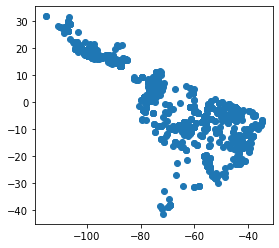

In [103]:
# Plot
gdf_SD_v1.plot()

In [104]:
socialData = pd.read_excel(r'SocialData_V1.xlsx')

In [105]:
socialData

,_id,country,typename,gender,ethnic,Res_defend,defending_from,typeviolence,Yearviolence,LONG,LAT,Stateresponsab
0,5c360846e52e9800164cb03e,CO,Persona,Hombre,No,Aire,Minería,Asesinato,2017,-73.746430,9.661436,Sin Información
1,5c3d17652be0a800163d05fa,EC,Persona,Hombre,Sí,Tierra,Minería,Acoso Judicial,2016,-78.375955,-3.256766,Sí
2,5c3d1ad72be0a800163d05fb,EC,Persona,Hombre,Sí,Tierra,Minería,Acoso Judicial,2016,-78.375955,-3.256766,Sí
3,5c3e1b9c1df21500167a2b80,EC,Persona,Hombre,Sí,Tierra,Minería,Ataque Directo,2016,-78.375955,-3.256766,Sí
4,5c3e1eea1df21500167a2b81,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2013,-78.062124,-2.342605,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...
2145,604cffea0325c100177fd1d9,CO,Persona,Mujer,Sí,Tierra,S_i,Asesinato,2018,-76.811322,2.452695,Sin Información
2146,604d15320325c100177fd1e0,CO,Persona,Hombre,Sí,Tierra,S_i,Asesinato,2012,-76.062313,8.171571,Sin Información
2147,604d16e80325c100177fd1e1,CO,Persona,Hombre,Sí,Tierra,S_i,Asesinato,2012,-76.062313,8.171571,Sin Información
2148,604d24c2c75e1e00170960f3,CO,Persona,Hombre,Sí,Tierra,S_i,Desplazamiento,2015,-75.198563,7.979698,Sin Información


In [106]:
gdf_SD = gpd.GeoDataFrame(
    socialData, geometry=gpd.points_from_xy(socialData.LONG, socialData.LAT))

<AxesSubplot:>

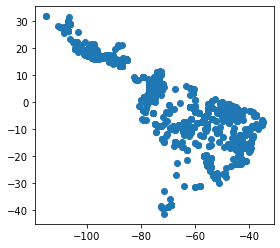

In [107]:
gdf_SD.plot()

In [108]:
gdf_SD

,_id,country,typename,gender,ethnic,Res_defend,defending_from,typeviolence,Yearviolence,LONG,LAT,Stateresponsab,geometry
0,5c360846e52e9800164cb03e,CO,Persona,Hombre,No,Aire,Minería,Asesinato,2017,-73.746430,9.661436,Sin Información,POINT (-73.74643 9.66144)
1,5c3d17652be0a800163d05fa,EC,Persona,Hombre,Sí,Tierra,Minería,Acoso Judicial,2016,-78.375955,-3.256766,Sí,POINT (-78.37596 -3.25677)
2,5c3d1ad72be0a800163d05fb,EC,Persona,Hombre,Sí,Tierra,Minería,Acoso Judicial,2016,-78.375955,-3.256766,Sí,POINT (-78.37596 -3.25677)
3,5c3e1b9c1df21500167a2b80,EC,Persona,Hombre,Sí,Tierra,Minería,Ataque Directo,2016,-78.375955,-3.256766,Sí,POINT (-78.37596 -3.25677)
4,5c3e1eea1df21500167a2b81,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2013,-78.062124,-2.342605,Sí,POINT (-78.06212 -2.34260)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,604cffea0325c100177fd1d9,CO,Persona,Mujer,Sí,Tierra,S_i,Asesinato,2018,-76.811322,2.452695,Sin Información,POINT (-76.81132 2.45269)
2146,604d15320325c100177fd1e0,CO,Persona,Hombre,Sí,Tierra,S_i,Asesinato,2012,-76.062313,8.171571,Sin Información,POINT (-76.06231 8.17157)
2147,604d16e80325c100177fd1e1,CO,Persona,Hombre,Sí,Tierra,S_i,Asesinato,2012,-76.062313,8.171571,Sin Información,POINT (-76.06231 8.17157)
2148,604d24c2c75e1e00170960f3,CO,Persona,Hombre,Sí,Tierra,S_i,Desplazamiento,2015,-75.198563,7.979698,Sin Información,POINT (-75.19856 7.97970)


In [109]:
# Filter
SD_2019 = gdf_SD[gdf_SD['Yearviolence'] == 2009]

In [110]:
# Filter
SD_2019[SD_2019['gender'] =='Hombre']

,_id,country,typename,gender,ethnic,Res_defend,defending_from,typeviolence,Yearviolence,LONG,LAT,Stateresponsab,geometry
31,5c4fcdd45edf8b00176dbf14,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2009,-79.219983,-2.861475,Sí,POINT (-79.21998 -2.86148)
35,5c50944190b56800174aaef9,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2009,-79.219983,-2.861475,Sí,POINT (-79.21998 -2.86148)
41,5c50b18290b56800174aaf00,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2009,-79.219983,-2.861475,Sí,POINT (-79.21998 -2.86148)
148,5c70577265298300175878fc,MX,Persona,Hombre,Sí,Agua,Infraestructura,Crim_Estig,2009,-98.137366,20.293271,Sí,POINT (-98.13737 20.29327)
149,5c70590865298300175878fd,MX,Persona,Hombre,Sí,Agua,Infraestructura,Crim_Estig,2009,-98.137366,20.293271,Sí,POINT (-98.13737 20.29327)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,5ca5955ff1b193001715e66c,GT,Persona,Hombre,Sí,Tierra,Minería,Ataque Directo,2009,-89.401564,15.451593,Sin Información,POINT (-89.40156 15.45159)
1296,5cacc5080518b20017118e88,PE,Persona,Hombre,No,Bosque,Tala,Amenaza,2009,-70.285101,-12.048038,Sin Información,POINT (-70.28510 -12.04804)
1297,5cacdfab0518b20017118e8a,CO,Persona,Hombre,No,Agua,Hidroeléctrica,Asesinato,2009,-73.169265,7.073968,Sin Información,POINT (-73.16927 7.07397)
1495,5e3ad3950dfc9c00174f35db,HN,Persona,Hombre,No,Tierra,Agroindustria,Asesinato,2009,-85.939829,15.830485,Sin Información,POINT (-85.93983 15.83048)


In [111]:
polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
polygons_copia = polygons.copy()

In [112]:
def count_events(year, gender, polygons_):
    import geopandas as gpd

    # Read the data.
    polygons = polygons_
    #polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
    #points = gpd.GeoDataFrame.from_file('points.shp')
    #polygons = countriesC
    points = gdf_SD[(gdf_SD['Yearviolence']==year) & (gdf_SD['gender']==gender)]
    # Make a copy because I'm going to drop points as I
    # assign them to polys, to speed up subsequent search.
    pts = points.copy() 

    # We're going to keep a list of how many points we find.
    pts_in_polys = []

    # Loop over polygons with index i.
    for i, poly in polygons.iterrows():

        # Keep a list of points in this poly
        pts_in_this_poly = []

        # Now loop over all points with index j.
        for j, pt in pts.iterrows():
            if poly.geometry.contains(pt.geometry):
                # Then it's a hit! Add it to the list,
                # and drop it so we have less hunting.
                pts_in_this_poly.append(pt.geometry)
                pts = pts.drop([j])

        # We could do all sorts, like grab a property of the
        # points, but let's just append the number of them.
        pts_in_polys.append(len(pts_in_this_poly))

    # Add the number of points for each poly to the dataframe.
    polygons['G'+gender+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
    return polygons

In [113]:
yearCount = np.arange(2009, 2020)
gender_ = ['Hombre', 'Mujer', 'No Aplica', 'S_i']
name_G = ['M', 'W', 'NA', 'S_i']
for i in yearCount:
    for j in gender_:
        Dataset30 = count_events(i, j, polygons_copia)
Dataset30

<ipython-input-112-2113882458b5>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['G'+gender+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-112-2113882458b5>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['G'+gender+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-112-2113882458b5>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['G'+gender+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-112-2113882458b5>:36: FutureWarning:     You a

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,GNo Aplica_2017,GS_i_2017,GHombre_2018,GMujer_2018,GNo Aplica_2018,GS_i_2018,GHombre_2019,GMujer_2019,GNo Aplica_2019,GS_i_2019
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,0,0,0,0,0,0,0,0,0,0
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,0,0,0,0,0,0,0,0,0,0
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,0,0,0,0,0,0,0,0,0,0
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,0,0,0,0,0,0,0,0,0,0
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,0,0,0,0,0,0,0,0,0,0
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,0,0,0,0,0,0,0,0,0,0
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,0,0,0,0,0,0,0,0,0,0


In [114]:
def count_events(year, defending, polygons_):
    import geopandas as gpd

    # Read the data.
    polygons = polygons_
    #polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
    #points = gpd.GeoDataFrame.from_file('points.shp')
    #polygons = countriesC
    points = gdf_SD[(gdf_SD['Yearviolence']==year) & (gdf_SD['Res_defend']==defending)]
    # Make a copy because I'm going to drop points as I
    # assign them to polys, to speed up subsequent search.
    pts = points.copy() 

    # We're going to keep a list of how many points we find.
    pts_in_polys = []

    # Loop over polygons with index i.
    for i, poly in polygons.iterrows():

        # Keep a list of points in this poly
        pts_in_this_poly = []

        # Now loop over all points with index j.
        for j, pt in pts.iterrows():
            if poly.geometry.contains(pt.geometry):
                # Then it's a hit! Add it to the list,
                # and drop it so we have less hunting.
                pts_in_this_poly.append(pt.geometry)
                pts = pts.drop([j])

        # We could do all sorts, like grab a property of the
        # points, but let's just append the number of them.
        pts_in_polys.append(len(pts_in_this_poly))

    # Add the number of points for each poly to the dataframe.
    polygons[defending+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
    return polygons

In [115]:
yearCount = np.arange(2009, 2020)
defending_ = ['Agua', 'Aire', 'Bosque', 'Especies', 'Tierra']
name_G = ['M', 'W', 'NA', 'S_i']
for i in yearCount:
    for j in defending_:
        Dataset30 = count_events(i, j, Dataset30)
Dataset30

<ipython-input-114-44a44cef4be7>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[defending+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-114-44a44cef4be7>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[defending+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-114-44a44cef4be7>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[defending+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-114-44a44cef4be7>:36: FutureWarning:     You are 

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,Agua_2018,Aire_2018,Bosque_2018,Especies_2018,Tierra_2018,Agua_2019,Aire_2019,Bosque_2019,Especies_2019,Tierra_2019
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,0,0,0,0,0,0,0,0,0,0
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,0,0,0,0,0,0,0,0,0,0
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,0,0,0,0,0,0,0,0,0,0
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,0,0,0,0,0,0,0,0,0,0
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,0,0,0,0,0,0,0,0,0,0
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,0,0,0,0,0,0,0,0,0,0
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,0,0,0,0,0,0,0,0,0,0


In [116]:
def count_events(year, def_from, polygons_):
    import geopandas as gpd

    # Read the data.
    polygons = polygons_
    #polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
    #points = gpd.GeoDataFrame.from_file('points.shp')
    #polygons = countriesC
    points = gdf_SD[(gdf_SD['Yearviolence']==year) & (gdf_SD['defending_from']==def_from)]
    # Make a copy because I'm going to drop points as I
    # assign them to polys, to speed up subsequent search.
    pts = points.copy() 

    # We're going to keep a list of how many points we find.
    pts_in_polys = []

    # Loop over polygons with index i.
    for i, poly in polygons.iterrows():

        # Keep a list of points in this poly
        pts_in_this_poly = []

        # Now loop over all points with index j.
        for j, pt in pts.iterrows():
            if poly.geometry.contains(pt.geometry):
                # Then it's a hit! Add it to the list,
                # and drop it so we have less hunting.
                pts_in_this_poly.append(pt.geometry)
                pts = pts.drop([j])

        # We could do all sorts, like grab a property of the
        # points, but let's just append the number of them.
        pts_in_polys.append(len(pts_in_this_poly))

    # Add the number of points for each poly to the dataframe.
    polygons[def_from+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
    return polygons

In [117]:
yearCount = np.arange(2009, 2020)
from_ = ['Agroindustria', 'Caza_traficoBiod', 'Energía', 'Forestal', 'Hidrocarburos', 'Hidroeléctrica', 
            'Infraestructura', 'Minería', 'Narcotráfico', 'Pesquería', 'Residuos', 'S_i', 'Tala', 'Turismo',
            'Especula_Inmob']

for i in yearCount:
    for j in from_:
        Dataset30 = count_events(i, j, Dataset30)
Dataset30

<ipython-input-116-71584ad0a19b>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[def_from+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-116-71584ad0a19b>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[def_from+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-116-71584ad0a19b>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[def_from+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-116-71584ad0a19b>:36: FutureWarning:     You are pas

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,Hidroeléctrica_2019,Infraestructura_2019,Minería_2019,Narcotráfico_2019,Pesquería_2019,Residuos_2019,S_i_2019,Tala_2019,Turismo_2019,Especula_Inmob_2019
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,0,0,0,0,0,0,0,0,0,0
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,0,0,0,0,0,0,0,0,0,0
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,0,0,0,0,0,0,0,0,0,0
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,0,0,0,0,0,0,0,0,0,0
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,0,0,0,0,0,0,0,0,0,0
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,0,0,0,0,0,0,0,0,0,0
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,0,0,0,0,0,0,0,0,0,0


In [118]:
def count_events(year, typeviol, polygons_):
    import geopandas as gpd

    # Read the data.
    polygons = polygons_
    #polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
    #points = gpd.GeoDataFrame.from_file('points.shp')
    #polygons = countriesC
    points = gdf_SD[(gdf_SD['Yearviolence']==year) & (gdf_SD['typeviolence']==typeviol)]
    # Make a copy because I'm going to drop points as I
    # assign them to polys, to speed up subsequent search.
    pts = points.copy() 

    # We're going to keep a list of how many points we find.
    pts_in_polys = []

    # Loop over polygons with index i.
    for i, poly in polygons.iterrows():

        # Keep a list of points in this poly
        pts_in_this_poly = []

        # Now loop over all points with index j.
        for j, pt in pts.iterrows():
            if poly.geometry.contains(pt.geometry):
                # Then it's a hit! Add it to the list,
                # and drop it so we have less hunting.
                pts_in_this_poly.append(pt.geometry)
                pts = pts.drop([j])

        # We could do all sorts, like grab a property of the
        # points, but let's just append the number of them.
        pts_in_polys.append(len(pts_in_this_poly))

    # Add the number of points for each poly to the dataframe.
    polygons[typeviol+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
    return polygons

In [119]:
yearCount = np.arange(2009, 2020)
violence_ = ['Acoso Judicial','Amenaza','Asesinato','Ataque Directo','Desaparecido','Desplazamiento',
         'Otro','S_i','Violencia Sexual','Crim_Estig']

for i in yearCount:
    for j in violence_:
        Dataset30 = count_events(i, j, Dataset30)
Dataset30

<ipython-input-118-8ac5099667c7>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[typeviol+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-118-8ac5099667c7>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[typeviol+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-118-8ac5099667c7>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons[typeviol+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-118-8ac5099667c7>:36: FutureWarning:     You are pas

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,Crim_Estig_2018,Acoso Judicial_2019,Amenaza_2019,Asesinato_2019,Ataque Directo_2019,Desaparecido_2019,Desplazamiento_2019,Otro_2019,Violencia Sexual_2019,Crim_Estig_2019
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,0,0,0,0,0,0,0,0,0,0
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,0,0,0,0,0,0,0,0,0,0
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,0,0,0,0,0,0,0,0,0,0
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,0,0,0,0,0,0,0,0,0,0
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,0,0,0,0,0,0,0,0,0,0
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,0,0,0,0,0,0,0,0,0,0
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,0,0,0,0,0,0,0,0,0,0


In [120]:
def count_events(year, ethnic, polygons_):
    import geopandas as gpd

    # Read the data.
    polygons = polygons_
    #polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
    #points = gpd.GeoDataFrame.from_file('points.shp')
    #polygons = countriesC
    points = gdf_SD[(gdf_SD['Yearviolence']==year) & (gdf_SD['ethnic']==ethnic)]
    # Make a copy because I'm going to drop points as I
    # assign them to polys, to speed up subsequent search.
    pts = points.copy() 

    # We're going to keep a list of how many points we find.
    pts_in_polys = []

    # Loop over polygons with index i.
    for i, poly in polygons.iterrows():

        # Keep a list of points in this poly
        pts_in_this_poly = []

        # Now loop over all points with index j.
        for j, pt in pts.iterrows():
            if poly.geometry.contains(pt.geometry):
                # Then it's a hit! Add it to the list,
                # and drop it so we have less hunting.
                pts_in_this_poly.append(pt.geometry)
                pts = pts.drop([j])

        # We could do all sorts, like grab a property of the
        # points, but let's just append the number of them.
        pts_in_polys.append(len(pts_in_this_poly))

    # Add the number of points for each poly to the dataframe.
    polygons['Eth_'+ethnic+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
    return polygons

In [121]:
yearCount = np.arange(2009, 2020)
ethnic_ = ['No', 'Sí', 'S_i']

for i in yearCount:
    for j in ethnic_:
        Dataset30 = count_events(i, j, Dataset30)
Dataset30

<ipython-input-120-daf6e167a247>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['Eth_'+ethnic+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-120-daf6e167a247>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['Eth_'+ethnic+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-120-daf6e167a247>:36: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['Eth_'+ethnic+'_'+str(year)] = gpd.GeoSeries(pts_in_polys)
<ipython-input-120-daf6e167a247>:36: FutureWarning: 

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,Eth_S_i_2016,Eth_No_2017,Eth_Sí_2017,Eth_S_i_2017,Eth_No_2018,Eth_Sí_2018,Eth_S_i_2018,Eth_No_2019,Eth_Sí_2019,Eth_S_i_2019
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,0,0,0,0,0,0,0,0,0,0
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,0,0,0,0,0,0,0,0,0,0
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,0,0,0,0,0,0,0,0,0,0
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,0,0,0,0,0,0,0,0,0,0
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,0,0,0,0,0,0,0,0,0,0
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,0,0,0,0,0,0,0,0,0,0
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,0,0,0,0,0,0,0,0,0,0


In [122]:
columnsDataset = pd.Series(Dataset30.columns)

In [123]:
gdf_SD[(gdf_SD['Yearviolence']==2009) & (gdf_SD['gender']=='Hombre')]

,_id,country,typename,gender,ethnic,Res_defend,defending_from,typeviolence,Yearviolence,LONG,LAT,Stateresponsab,geometry
31,5c4fcdd45edf8b00176dbf14,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2009,-79.219983,-2.861475,Sí,POINT (-79.21998 -2.86148)
35,5c50944190b56800174aaef9,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2009,-79.219983,-2.861475,Sí,POINT (-79.21998 -2.86148)
41,5c50b18290b56800174aaf00,EC,Persona,Hombre,Sí,Agua,Minería,Acoso Judicial,2009,-79.219983,-2.861475,Sí,POINT (-79.21998 -2.86148)
148,5c70577265298300175878fc,MX,Persona,Hombre,Sí,Agua,Infraestructura,Crim_Estig,2009,-98.137366,20.293271,Sí,POINT (-98.13737 20.29327)
149,5c70590865298300175878fd,MX,Persona,Hombre,Sí,Agua,Infraestructura,Crim_Estig,2009,-98.137366,20.293271,Sí,POINT (-98.13737 20.29327)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,5ca5955ff1b193001715e66c,GT,Persona,Hombre,Sí,Tierra,Minería,Ataque Directo,2009,-89.401564,15.451593,Sin Información,POINT (-89.40156 15.45159)
1296,5cacc5080518b20017118e88,PE,Persona,Hombre,No,Bosque,Tala,Amenaza,2009,-70.285101,-12.048038,Sin Información,POINT (-70.28510 -12.04804)
1297,5cacdfab0518b20017118e8a,CO,Persona,Hombre,No,Agua,Hidroeléctrica,Asesinato,2009,-73.169265,7.073968,Sin Información,POINT (-73.16927 7.07397)
1495,5e3ad3950dfc9c00174f35db,HN,Persona,Hombre,No,Tierra,Agroindustria,Asesinato,2009,-85.939829,15.830485,Sin Información,POINT (-85.93983 15.83048)


# *¡Aquí!*

In [124]:
columnsDataset.to_excel("xlsx\columnsDatasetName.xlsx")

In [125]:
Dataset30.to_file('./outputs_zonalStatistic/SocialDataset_30.gpkg', driver="GPKG")

In [126]:
columnData30 = pd.Series(Dataset30.columns)

In [127]:
Dataset30

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,Eth_S_i_2016,Eth_No_2017,Eth_Sí_2017,Eth_S_i_2017,Eth_No_2018,Eth_Sí_2018,Eth_S_i_2018,Eth_No_2019,Eth_Sí_2019,Eth_S_i_2019
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,0,0,0,0,0,0,0,0,0,0
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,0,0,0,0,0,0,0,0,0,0
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,0,0,0,0,0,0,0,0,0,0
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,0,0,0,0,0,0,0,0,0,0
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,0,0,0,0,0,0,0,0,0,0
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,0,0,0,0,0,0,0,0,0,0
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,0,0,0,0,0,0,0,0,0,0


In [128]:
columnData30.str.replace('Eth_Sí_', 'Et')

0         ADM2_CODE
1         ADM1_CODE
2         ADM2_NAME
3         ADM1_NAME
4        Shape_Leng
           ...     
436          Et2018
437    Eth_S_i_2018
438     Eth_No_2019
439          Et2019
440    Eth_S_i_2019
Length: 441, dtype: object

In [129]:
import geyearCount as gpd

# Read the data.
polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
#points = gpd.GeoDataFrame.from_file('points.shp')
#polygons = countriesC
points = gdf_SD
# Make a copy because I'm going to drop points as I
# assign them to polys, to speed up subsequent search.
pts = points.copy() 

# We're going to keep a list of how many points we find.
pts_in_polys = []

# Loop over polygons with index i.
for i, poly in polygons.iterrows():

    # Keep a list of points in this poly
    pts_in_this_poly = []

    # Now loop over all points with index j.
    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            # Then it's a hit! Add it to the list,
            # and drop it so we have less hunting.
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])

    # We could do all sorts, like grab a property of the
    # points, but let's just append the number of them.
    pts_in_polys.append(len(pts_in_this_poly))

# Add the number of points for each poly to the dataframe.
polygons['number of points'] = gpd.GeoSeries(pts_in_polys)

<ipython-input-129-ba56b4e69ed7>:34: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['number of points'] = gpd.GeoSeries(pts_in_polys)


******

In [130]:
sdata = gpd.read_file(r'outputs_zonalStatistic/SocialDataset_30.gpkg')

In [131]:
sdata.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'Shape_Leng',
       'STATUS', 'ADM0_NAME', 'Shape_Area', 'DEF30_2009', 'DEF30_2010',
       ...
       'Eth_No_2017', 'Eth_Sí_2017', 'Eth_S_i_2017', 'Eth_No_2018',
       'Eth_Sí_2018', 'Eth_S_i_2018', 'Eth_No_2019', 'Eth_Sí_2019',
       'Eth_S_i_2019', 'geometry'],
      dtype='object', length=441)

In [132]:
Sdata = sdata.copy()

In [133]:
pd.Series(Sdata.columns)

0         ADM2_CODE
1         ADM1_CODE
2         ADM2_NAME
3         ADM1_NAME
4        Shape_Leng
           ...     
436    Eth_S_i_2018
437     Eth_No_2019
438     Eth_Sí_2019
439    Eth_S_i_2019
440        geometry
Length: 441, dtype: object

In [134]:
columnsName = pd.read_excel('columnsName1.xlsx')

In [135]:
columnsName.columns

#columnsName.rename(columns = {'fid.1':'fid_1'}, inplace = True)

Index(['fid', 'fid2'], dtype='object')

In [136]:
columnsName

,fid,fid2
0,ADM1_CODE,ADM1_CODE
1,ADM2_NAME,ADM2_NAME
2,ADM1_NAME,ADM1_NAME
3,Shape_Leng,Shape_Leng
4,STATUS,STATUS
...,...,...
434,Eth_Sí_2018,Et_Sí_2018
435,Eth_S_i_2018,EtnoIn2018
436,Eth_No_2019,Et_No_2019
437,Eth_Sí_2019,Et_Sí_2019


In [137]:
columnsName

columnsName.loc[len(columnsName.index)] = ['geometry', 'geometry']

In [138]:
zip_ = zip(columnsName.fid, columnsName.fid2)

In [139]:
lzip = list(zip(columnsName.fid, columnsName.fid2))

In [140]:
lzip

[('ADM1_CODE', 'ADM1_CODE'),
 ('ADM2_NAME', 'ADM2_NAME'),
 ('ADM1_NAME', 'ADM1_NAME'),
 ('Shape_Leng', 'Shape_Leng'),
 ('STATUS', 'STATUS'),
 ('ADM0_NAME', 'ADM0_NAME'),
 ('Shape_Area', 'Shape_Area'),
 ('DEF30_2009', 'DEF30_2009'),
 ('DEF30_2010', 'DEF30_2010'),
 ('DEF30_2011', 'DEF30_2011'),
 ('DEF30_2012', 'DEF30_2012'),
 ('DEF30_2013', 'DEF30_2013'),
 ('DEF30_2014', 'DEF30_2014'),
 ('DEF30_2015', 'DEF30_2015'),
 ('DEF30_2016', 'DEF30_2016'),
 ('DEF30_2017', 'DEF30_2017'),
 ('DEF30_2018', 'DEF30_2018'),
 ('DEF30_2019', 'DEF30_2019'),
 ('forest30ha', 'forest30ha'),
 ('Area_ha', 'Area_ha'),
 ('P_2009', 'P_2009'),
 ('P_2010', 'P_2010'),
 ('P_2011', 'P_2011'),
 ('P_2012', 'P_2012'),
 ('P_2013', 'P_2013'),
 ('P_2014', 'P_2014'),
 ('P_2015', 'P_2015'),
 ('P_2016', 'P_2016'),
 ('P_2017', 'P_2017'),
 ('P_2018', 'P_2018'),
 ('P_2019', 'P_2019'),
 ('GPD2009', 'GPD2009'),
 ('GPD2010', 'GPD2010'),
 ('GPD2011', 'GPD2011'),
 ('GPD2012', 'GPD2012'),
 ('GPD2013', 'GPD2013'),
 ('GPD2014', 'GPD2014'),

In [141]:
dictzip = dict(zip(columnsName.fid, columnsName.fid2))

In [142]:
Sdata = Sdata.rename(columns=dictzip)
#Sdata=Sdata.rename(columns=dictzip, inplace=True)

In [143]:
Sdata

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,DEF30_2009,DEF30_2010,...,Et_No_2017,Et_Sí_2017,EtnoIn2017,Et_No_2018,Et_Sí_2018,EtnoIn2018,Et_No_2019,Et_Sí_2019,EtnoIn2019,geometry
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,3.560471,23.911765,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-61.71147 -27.05840, -61.71124 -27.0..."
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,2.070000,5.490000,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-61.56972 -27.55519, -61.56964 -27.4..."
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,1.344000,11.439529,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-61.71047 -27.99748, -61.71044 -27.9..."
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-58.33218 -34.80489, -58.33122 -34.8..."
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,0.180000,0.000000,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-58.49034 -34.92710, -58.48491 -34.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,5.494941,2.238706,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-71.54085 10.54964, -71.54067 10.550..."
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,14.750118,8.742353,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-71.19316 9.22502, -71.19225 9..."
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,21.656824,23.961529,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-71.15427 9.94591, -71.15375 9..."
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,7.068000,3.330706,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-67.36462 10.53791, -67.36434 10.537..."


<AxesSubplot:>

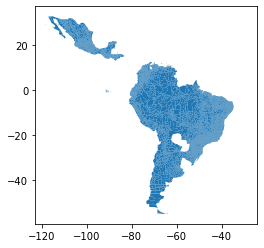

In [144]:
Sdata_ = Sdata.copy()
Sdata_.plot()

In [145]:
Sdata_.columns

Index(['ADM2_CODE', 'ADM1_CODE', 'ADM2_NAME', 'ADM1_NAME', 'Shape_Leng',
       'STATUS', 'ADM0_NAME', 'Shape_Area', 'DEF30_2009', 'DEF30_2010',
       ...
       'Et_No_2017', 'Et_Sí_2017', 'EtnoIn2017', 'Et_No_2018', 'Et_Sí_2018',
       'EtnoIn2018', 'Et_No_2019', 'Et_Sí_2019', 'EtnoIn2019', 'geometry'],
      dtype='object', length=441)

In [152]:
def coucolumnsents(year, polygons_):
    import geopandas as gpd

    # Read the data.
    polygons = polygons_
    #polygons = gpd.GeoDataFrame.from_file('SHP/Dataset.shp')
    #points = gpd.GeoDataFrame.from_file('points.shp')
    #polygons = countriesC
    points = gdf_SD[(gdf_SD['Yearviolence']==year)]
    # Make a copy because I'm going to drop points as I
    # assign them to polys, to speed up subsequent search.
    pts = points.copy() 

    # We're going to keep a list of how many points we find.
    pts_in_polys = []

    # Loop over polygons with index i.
    for i, poly in polygons.iterrows():

        # Keep a list of points in this poly
        pts_in_this_poly = []

        # Now loop over all points with index j.
        for j, pt in pts.iterrows():
            if poly.geometry.contains(pt.geometry):
                # Then it's a hit! Add it to the list,
                # and drop it so we have less hunting.
                pts_in_this_poly.append(pt.geometry)
                pts = pts.drop([j])

        # We could do all sorts, like grab a property of the
        # points, but let's just append the number of them.
        pts_in_polys.append(len(pts_in_this_poly))

    # Add the number of points for each poly to the dataframe.
    polygons['events'+str(year)] = gpd.GeoSeries(pts_in_polys)
    return polygons

In [153]:
yearCount = np.arange(2009, 2020)

for i in yearCount:
    Sdata_ = count_events(i, Sdata_)
Sdata_

TypeError: count_events() missing 1 required positional argument: 'polygons_'

In [ ]:
for i in yearCount:
    Sdata_['PD_'+str(i)] = (Sdata_['P_'+str(i)])/(Sdata_['Area_ha']/100)
Sdata_

In [180]:
Sdata_.to_file("SHP/dataset30_f.shp")

In [181]:
Sdata30_ = Sdata.copy()
Sdata30_ = Sdata30_.drop(['DEF30_2009', 'DEF30_2010', 'DEF30_2011', 'DEF30_2012',
       'DEF30_2013', 'DEF30_2014', 'DEF30_2015', 'DEF30_2016', 'DEF30_2017',
       'DEF30_2018', 'DEF30_2019', 'forest30ha'], axis=1)

In [299]:
sdata50 = gpd.read_file(r'outputs_zonalStatistic/threshold_50.gpkg')
sdata50_ = sdata50.copy()
sdata50_  = sdata50_ .rename(columns={'ADM1_CODE': 'ADM1_CODE', 'ADM2_CODE': 'ADM2_CODE', 'ADM2_NAME': 'ADM2_NAME', 
                                      'ADM1_NAME':'ADM1_NAME', 'Shape_Leng':'Shape_Leng', 'STATUS':'STATUS',
                                      'ADM0_NAME': 'ADM0_NAME', 'Shape_Area':'Shape_Area', 'loss50_ha_2009': 'Def2009_ha',
                                      'loss50_ha_2010': 'Def2010_ha', 'loss50_ha_2011': 'Def2011_ha',
                                      'loss50_ha_2012': 'Def2012_ha', 'loss50_ha_2013': 'Def2013_ha',
                                      'loss50_ha_2014': 'Def2014_ha', 'loss50_ha_2015': 'Def2015_ha',
                                      'loss50_ha_2016': 'Def2016_ha', 'loss50_ha_2017': 'Def2017_ha',
                                      'loss50_ha_2018': 'Def2018_ha', 'loss50_ha_2019': 'Def2019_ha',
                                      'forest_50': 'forest50ha'})

sdata50_  = sdata50_ .rename(columns={'ADM1_CODE': 'ADM1_CODE', 'ADM2_NAME': 'ADM2_NAME', 'ADM2_CODE': 'ADM2_CODE', 
                                      'ADM1_NAME':'ADM1_NAME', 'Shape_Leng':'Shape_Leng', 'STATUS':'STATUS',
                                      'ADM0_NAME': 'ADM0_NAME', 'Shape_Area':'Shape_Area', 'Def2009_ha': 'DEF50_2009',
                                      'Def2010_ha':'DEF50_2010', 'Def2011_ha':'DEF50_2011', 'Def2012_ha':'DEF50_2012',
                                      'Def2013_ha':'DEF50_2013', 'Def2014_ha':'DEF50_2014', 'Def2015_ha':'DEF50_2015',
                                      'Def2016_ha':'DEF50_2016', 'Def2017_ha':'DEF50_2017', 'Def2018_ha':'DEF50_2018',
                                      'Def2019_ha':'DEF50_2019', 'forest50ha': 'forest50ha'})


In [300]:
sdata50_ = sdata50_.drop(['ADM1_CODE', 'ADM1_NAME', 'Shape_Leng', 'STATUS', 'EXP2_YEAR', 'DISP_AREA', 'STR2_YEAR',
       'ADM0_CODE', 'ADM0_NAME', 'Shape_Area', 'geometry', 'loss50_ha_2020'], axis=1)

In [301]:
sdata50_.columns

Index(['ADM2_CODE', 'ADM2_NAME', 'DEF50_2009', 'DEF50_2010', 'DEF50_2011',
       'DEF50_2012', 'DEF50_2013', 'DEF50_2014', 'DEF50_2015', 'DEF50_2016',
       'DEF50_2017', 'DEF50_2018', 'DEF50_2019', 'forest50ha'],
      dtype='object')

In [323]:
a = sdata50['ADM2_CODE'] == Sdata30_['ADM2_CODE']
for i in a:
    if i == False:
        print(i)
        print('Hay no coincidencia')
        break    

True
Hay no coincidencia


In [303]:
sdata50_

,ADM2_CODE,ADM2_NAME,DEF50_2009,DEF50_2010,DEF50_2011,DEF50_2012,DEF50_2013,DEF50_2014,DEF50_2015,DEF50_2016,DEF50_2017,DEF50_2018,DEF50_2019,forest50ha
0,82755,12 de Octubre,2.486118,14.124706,66.184941,50.842941,15.635294,19.302000,11.397882,7.950706,11.965765,24.750000,3.510000,671.557412
1,82756,2 de Abril,0.990000,2.700000,5.310000,3.510000,6.929647,7.459059,0.180000,0.518824,0.810000,1.530000,3.330000,130.523647
2,82757,Fray Justo Santa Maria de Oro,0.573882,7.456941,1.991294,1.802118,4.409647,0.630000,0.180000,0.630000,0.540000,1.170000,2.208706,110.956588
3,82728,Florencio Varela,0.000000,0.000000,0.090000,0.000000,0.025412,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397059
4,82736,Presidente Peron,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.790941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,Santa Rita,2.610000,1.158706,0.985412,3.004588,4.748824,6.327529,5.010000,1.890000,4.275176,3.639529,1.938353,94.439294
10484,32172,Sucre,8.937176,5.491059,3.706588,4.143176,1.693059,2.629765,1.783765,3.459176,5.449412,2.557765,1.000941,98.420471
10485,32173,Valmore Rodriguez,18.858706,21.074471,11.506941,15.982941,2.894471,6.508235,4.680000,41.242588,124.316471,47.941765,12.981176,693.399176
10486,31960,Vargas,5.987647,2.520706,15.997412,13.763294,22.423412,4.942235,9.170118,10.070118,9.051176,13.140706,4.320000,919.602000


In [310]:
Sdata30_

,ADM2_CODE,ADM1_CODE,ADM2_NAME,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,Area_ha,P_2009,...,Et_No_2017,Et_Sí_2017,EtnoIn2017,Et_No_2018,Et_Sí_2018,EtnoIn2018,Et_No_2019,Et_Sí_2019,EtnoIn2019,geometry
0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,275133.203061,2.249331e+04,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-61.71147 -27.05840, -61.71124 -27.0..."
1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,160295.618816,7.587485e+03,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-61.56972 -27.55519, -61.56964 -27.4..."
2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,219609.890652,1.191248e+04,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-61.71047 -27.99748, -61.71044 -27.9..."
3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,19040.938408,4.255159e+05,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-58.33218 -34.80489, -58.33122 -34.8..."
4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,12067.769439,8.016397e+04,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-58.49034 -34.92710, -58.48491 -34.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,49796.347390,5.818051e+04,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-71.54085 10.54964, -71.54067 10.550..."
10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,73716.130218,6.191074e+04,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-71.19316 9.22502, -71.19225 9..."
10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,118794.270377,5.428716e+04,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-71.15427 9.94591, -71.15375 9..."
10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,99213.440509,3.545319e+05,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-67.36462 10.53791, -67.36434 10.537..."


In [337]:
dataset50 = Sdata30_.merge(sdata50_, on=Sdata30_.index, how='left')

In [335]:
type(dataset50['ADM2_CODE'])

pandas.core.series.Series

In [324]:
#dataset50 = pd.merge(Sdata30_, sdata50_, on='ADM2_CODE')

In [338]:
dataset50

,key_0,ADM2_CODE_x,ADM1_CODE,ADM2_NAME_x,ADM1_NAME,Shape_Leng,STATUS,ADM0_NAME,Shape_Area,Area_ha,...,DEF50_2011,DEF50_2012,DEF50_2013,DEF50_2014,DEF50_2015,DEF50_2016,DEF50_2017,DEF50_2018,DEF50_2019,forest50ha
0,0,82755,432,12 de Octubre,Chaco,2.658120,Member State,Argentina,0.250908,275133.203061,...,66.184941,50.842941,15.635294,19.302000,11.397882,7.950706,11.965765,24.750000,3.510000,671.557412
1,1,82756,432,2 de Abril,Chaco,1.730701,Member State,Argentina,0.146554,160295.618816,...,5.310000,3.510000,6.929647,7.459059,0.180000,0.518824,0.810000,1.530000,3.330000,130.523647
2,2,82757,432,Fray Justo Santa Maria de Oro,Chaco,2.487062,Member State,Argentina,0.201226,219609.890652,...,1.991294,1.802118,4.409647,0.630000,0.180000,0.630000,0.540000,1.170000,2.208706,110.956588
3,3,82728,429,Florencio Varela,Buenos Aires,0.771865,Member State,Argentina,0.018773,19040.938408,...,0.090000,0.000000,0.025412,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397059
4,4,82736,429,Presidente Peron,Buenos Aires,0.643710,Member State,Argentina,0.011906,12067.769439,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.790941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,10483,32171,3325,Santa Rita,Zulia,1.021265,Member State,Venezuela,0.041131,49796.347390,...,0.985412,3.004588,4.748824,6.327529,5.010000,1.890000,4.275176,3.639529,1.938353,94.439294
10484,10484,32172,3325,Sucre,Zulia,1.712832,Member State,Venezuela,0.060637,73716.130218,...,3.706588,4.143176,1.693059,2.629765,1.783765,3.459176,5.449412,2.557765,1.000941,98.420471
10485,10485,32173,3325,Valmore Rodriguez,Zulia,1.696619,Member State,Venezuela,0.098008,118794.270377,...,11.506941,15.982941,2.894471,6.508235,4.680000,41.242588,124.316471,47.941765,12.981176,693.399176
10486,10486,31960,67152,Vargas,Vargas,2.849637,Member State,Venezuela,0.081951,99213.440509,...,15.997412,13.763294,22.423412,4.942235,9.170118,10.070118,9.051176,13.140706,4.320000,919.602000


In [341]:
dataset50['ADM2_CODE_x'] == Sdata30_['ADM2_CODE']

0        True
1        True
2        True
3        True
4        True
         ... 
10483    True
10484    True
10485    True
10486    True
10487    True
Length: 10488, dtype: bool

In [342]:
dataset50.columns

Index(['key_0', 'ADM2_CODE_x', 'ADM1_CODE', 'ADM2_NAME_x', 'ADM1_NAME',
       'Shape_Leng', 'STATUS', 'ADM0_NAME', 'Shape_Area', 'Area_ha',
       ...
       'DEF50_2011', 'DEF50_2012', 'DEF50_2013', 'DEF50_2014', 'DEF50_2015',
       'DEF50_2016', 'DEF50_2017', 'DEF50_2018', 'DEF50_2019', 'forest50ha'],
      dtype='object', length=444)

In [329]:
dataset50_= dataset50.copy()

In [343]:
dataset50_ = dataset50_.drop(['ADM2_NAME_x'], axis=1)

KeyError: "['ADM2_NAME_x'] not found in axis"

In [344]:
dataset50_.to_file("SHP/dataset50_f.shp")

In [ ]:
#dataset50_ = dataset50.drop(['DEF30_2009', 'DEF30_2010', 'DEF30_2011','DEF30_2012', 'DEF30_2013', 'DEF30_2014','DEF30_2015', 'DEF30_2016', 'DEF30_2017','DEF30_2018', 'DEF30_2019', 'DEF30_2011',])axis=

In [16]:
datadata50 = gpd.read_file(r'SHP/dataset50_f.shp')

In [151]:
yearCount = np.arange(2009, 2020)

for i in yearCount:
    Sdata_ = count_events(i, datadata50)
Sdata_

TypeError: count_events() missing 1 required positional argument: 'polygons_'

In [182]:
Sdata_.to_file("SHP/dataset50_f.shp")

In [135]:
for i in Sdata_:
    print(i)

ADM1_CODE
ADM2_NAME
ADM1_NAME
Shape_Leng
STATUS
ADM0_NAME
Shape_Area
Area_ha
PD_2009
PD_2010
PD_2011
PD_2012
PD_2013
PD_2014
PD_2015
PD_2016
PD_2017
PD_2018
PD_2019
GPD2009
GPD2010
GPD2011
GPD2012
GPD2013
GPD2014
GPD2015
GPD2016
GPD2017
GPD2018
GPD2019
%Forest30
gM_2009
gF_2009
g_na_2009
g_noinf200
gM_2010
gF_2010
g_na_2010
g_noinf201
gM_2011
gF_2011
g_na_2011
g_noinf2_1
gM_2012
gF_2012
g_na_2012
g_noinf2_2
gM_2013
gF_2013
g_na_2013
g_noinf2_3
gM_2014
gF_2014
g_na_2014
g_noinf2_4
gM_2015
gF_2015
g_na_2015
g_noinf2_5
gM_2016
gF_2016
g_na_2016
g_noinf2_6
gM_2017
gF_2017
g_na_2017
g_noinf2_7
gM_2018
gF_2018
g_na_2018
g_noinf2_8
gM_2019
gF_2019
g_na_2019
g_noinf2_9
dWater2009
dAir2009
dFores2009
dSpeci2009
dLand2009
dWater2010
dAir2010
dFores2010
dSpeci2010
dLand2010
dWater2011
dAir2011
dFores2011
dSpeci2011
dLand2011
dWater2012
dAir2012
dFores2012
dSpeci2012
dLand2012
dWater2013
dAir2013
dFores2013
dSpeci2013
dLand2013
dWater2014
dAir2014
dFores2014
dSpeci2014
dLand2014
dWater2015
dAir201